<a href="https://colab.research.google.com/github/nicholasrichers/dissertacao/blob/master/C%C3%B3pia_de_25gb_ram_treinar_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RUNNING San_Francisco


## 1. Install GPU Libs


GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jan 27 03:21:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


Light GBM

In [3]:
%%capture
!git clone --recursive https://github.com/Microsoft/LightGBM

%cd /content/LightGBM
!mkdir build

!cmake -DUSE_GPU=1
!make -j$(nproc)


In [4]:
%%capture
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools numpy scipy scikit-learn -U

%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

%cd /content



---



---



XGboost

In [5]:
#%%capture
!pip install xgboost==1.2.0

     |████████████████████████████████| 148.9MB 27kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90




---



---



Sklearn

In [6]:
#%%capture
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.1

Uninstalling scikit-learn-0.24.1:
  Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 6.9MB 4.0MB/s 




---



---



## 1.1 Quick Setup dependencies

In [7]:
#checando versoes para evitar conflitos

import lightgbm as lgbm
print("lgbm version:", lgbm.__version__)

import xgboost as xgb
print("xgb version:", xgb.__version__)

import sklearn
print("sklearn version:", sklearn.__version__)

lgbm version: 3.1.1.99
xgb version: 1.2.0
sklearn version: 0.23.1


Git Clone

In [8]:
%%capture
!git clone https://github.com/nicholasrichers/dissertacao.git
!pip install scikit-optimize

Git Pull

In [9]:
%cd /content/dissertacao/
!git pull
%cd /content
#get_libs()

/content/dissertacao
Already up to date.
/content


## 1.2 Import libs

In [10]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

def load_library(NAME_LIB, FILE_PATH):
    from importlib.machinery import SourceFileLoader
    FILE_PATH = '/content/dissertacao/' + FILE_PATH
    somemodule = SourceFileLoader(NAME_LIB, FILE_PATH).load_module()
    

load_library('quick_setup', 'src/utils/quick_setup.py')

In [11]:
#import pandas as pd
from quick_setup import get_libs
get_libs()

In [12]:
#private modules 
#data
import make_dataset

#models
import train_model
import evaluation
import dsr
import meta_model
import neutralize
fn_strategy = neutralize.fn_strategy_dict

#validation
import group_ts_split
import combinatorial_split
import metrics
import metrics_era
import metrics_description
#import my_validation

#visualization
import visualize

In [13]:
#main libraries
import numpy as np
import pandas as pd
import scipy
from joblib import dump, load
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

#skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [14]:
#private class (tentar treinar com a classe da pasta [no colab] a o inves de colar local)
from sklearn.base import BaseEstimator, RegressorMixin
#class MyXGBRanker(XGBRanker, BaseEstimator, RegressorMixin):

from xgboost import XGBRanker
class MyXGBRanker(XGBRanker, BaseEstimator, RegressorMixin):
    def fit(self, x, y):
        cdf = x.groupby('era').agg(['count'])
        group = cdf[cdf.columns[0]].values
        return super().fit(x[features], y, group=group)

    def predict(self, x):
        return super().predict(x[features])

In [15]:
results = dict()
github_url = 'https://raw.githubusercontent.com/nicholasrichers/dissertacao/master/reports/predicoes_validacao/'

## 2. Download the datasets





### training

In [90]:
%%time
df_training,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=False, 
                                                    dataset="training", 
                                                    feather=False) #Apenas False colab/aws

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float64(311), int32(1), object(2)
memory usage: 1.2+ GB
None
CPU times: user 19.4 s, sys: 1.26 s, total: 20.6 s
Wall time: 40.7 s


### tournament

In [91]:
%%time
df_tournament,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=False, 
                                                    dataset="validation", #"tournament"
                                                    feather=False) #Apenas False colab/aws

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137779 entries, 0 to 137778
Columns: 314 entries, id to target
dtypes: float64(311), object(3)
memory usage: 330.1+ MB
None
CPU times: user 5.79 s, sys: 320 ms, total: 6.11 s
Wall time: 12.2 s


validation

In [92]:
df_validation = df_tournament[df_tournament.data_type == 'validation']
df_validation['era'] = df_validation.loc[:, 'era'].str[3:].astype('int32')

In [93]:
df_tournament=None

## 3. Validation Strategy & Metrics

In [20]:
#Group K-fold
CV = GroupKFold(n_splits = 3)
cv_grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))

In [21]:
#Group TS-fold
CV = group_ts_split.TimeSeriesSplitGroups(n_splits = 5)
ts_grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era))

In [22]:
#Group Slider-fold
CV = group_ts_split.TimeSeriesSplitGroups_Slider(n_splits = 5)
slider_grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era))

In [23]:
#Combinatorial K-fold
#CV = combinatorial_split.CombinatorialPurgedKFold(n_splits=12, n_test_splits=2, samples_info_sets=combinatorial_split.last_ix_series(df_training))
#cpcv_grp = list(CV.split(X = df_training[features], y = df_training['target'],  groups = df_training.era))

In [24]:
def eras_score(y_true, y_pred):

    #create y_true as df
    y_true = y_true.to_frame(name='target')
    y_true = y_true.join(df_training['era'])

    #create y_pred as df
    preds_df = pd.DataFrame(y_pred, index = y_true.index, columns=['preds'])
    preds_df = preds_df.join(df_training['era'])
    era_scores = pd.Series(index=y_true['era'].unique())

    for era in y_true['era'].unique():
        era_df = y_true[y_true['era'] == era]
        era_preds = preds_df[preds_df['era'] == era]
        era_scores[era] = np.corrcoef(era_df['target'], 
                                      era_preds['preds'].rank(pct=True, method="first"))[0,1]

    
    results = era_scores.to_frame()
    #results.to_csv(file_name_prov, mode='a', header=False, index=True)
    return era_scores


def validation_mean_(y_true, y_pred):
  era_scores = eras_score(y_true, y_pred)
  return np.mean(era_scores)


def annual_sharpe(x):
    return ((np.mean(x) -0.010415154) /np.std(x, ddof=1)) #* np.sqrt(12) 

from scipy.stats import skew, kurtosis, sem, gmean
def adj_sharpe_(y_true, y_pred):
  x = eras_score(y_true, y_pred)
  return annual_sharpe(x) * (1 + ((skew(x) / 6) * annual_sharpe(x)) - \
                             ((kurtosis(x) - 0) / 24) * (annual_sharpe(x) ** 2)) 




scorer = make_scorer(adj_sharpe_)

## 4. FN Strategy (Pre)

### FN Train (metrics)

In [ ]:
import scipy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

def _neutralize(df, columns, by, ml_model, proportion=1.0): #['preds'], features,
    scores = df[columns] #preds
    exposures = df[by].values #features
    ml_model[0].fit(exposures, scores.values.reshape(1,-1)[0])
    neutr_preds = pd.DataFrame(ml_model[0].predict(exposures), index=df.index, columns=columns)
    #exposures.dot(np.linalg.pinv(exposures).dot(scores))    

    
    if ml_model[1] != None:
        ml_model[1].fit(exposures, scores.values.reshape(1,-1)[0])
        neutr_preds2 = pd.DataFrame(ml_model[1].predict(exposures), index=df.index, columns=columns)

    else: neutr_preds2 = 0# np.zeros(len(scores))

    scores = scores - ((proportion * neutr_preds) + ((1-proportion) * neutr_preds2))
    #scores = scores - proportion * neutr_preds
    return scores / scores.std()



def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)


def normalize_and_neutralize(df, columns, by, ml_model, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    #df[columns] = _neutralize(df, columns, by, ml_model, proportion)
    return df[columns]
   


def preds_neutralized(df, columns, by, ml_model, proportion=1.0):

    preds_neutr = df.groupby("era").apply( lambda x: normalize_and_neutralize(x, columns, by, ml_model, proportion))

    preds_neutr = MinMaxScaler().fit_transform(preds_neutr).reshape(1,-1)[0]

    return preds_neutr

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
def adj_sharpe_fn_(y_true, y_pred):

  #create y_true as df
  y_true_ = y_true.to_frame(name='target')
  df_cv = y_true_.join(df_training[['era']+features])
  df_cv['preds'] = y_pred

  y_pred_fn = preds_neutralized(df_cv, ['preds'], features,
                                [LinearRegression(fit_intercept=False), Ridge(alpha=0.5)],
                                0.75)
                             #fn_strategy['nr__medellin']['model'], 
                             #fn_strategy['nr__medellin']['factor'])
  
  x = eras_score(y_true, y_pred_fn)
  return annual_sharpe(x) * (1 + ((skew(x) / 6) * annual_sharpe(x)) - \
                             ((kurtosis(x) - 0) / 24) * (annual_sharpe(x) ** 2)) 

#scorer = make_scorer(adj_sharpe_fn_)


In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate, GridSearchCV


#####################################################################
#####################################################################

space  = [
           #step 1 & 6
           Integer(1000, 4000, name='n_estimators', prior='uniform'), 
           Real(5**-3, 10**-1, name='learning_rate', prior='log-uniform'), 

           #step 2
           Integer(3, 10, name='max_depth', prior='uniform'),
           Integer(1, 10, name='min_child_weight', prior='uniform'),

           #step 3
           Real(1e-5, 6, name='gamma', prior='log-uniform'),

           #step 4
           Real(5e-2, .5, name='colsample_bytree', prior='uniform'),
           Real(5e-2, .5, name='subsample', prior='uniform'),
          
           #step 5
           Real(1, 100, name='reg_alpha', prior='log-uniform'),

]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):

    #model.set_params(**params)
    param_grid = {} #hparams in list []
    for key, val in params.items(): param_grid[key] = [val]
    print(params)

    #cria csv prov zerado aqui
    prov_scores =  pd.DataFrame(columns=['scores'])
    prov_scores.to_csv(file_name_prov, header=True, index=0)#df_training.era.unique

    #train model
    grid_search = GridSearchCV(model, param_grid, cv=cv_grp, n_jobs=-1, scoring=scorer)
    grid_search.fit(df_training[features], df_training[target])
    

    #get estimator and results
    model_ = grid_search.best_estimator_
    results = grid_search.cv_results_
    adj_sharpe_val = results['mean_test_score'][0]


    #predict and neutralize results
    df_validation['preds'] = model_.predict(df_validation[features])#.to_list()
    preds_test = neutralize.preds_neutralized(df_validation,
                                              ['preds'], 
                                              features,
                                              fn_strategy['nr__medellin']['model'], 
                                              fn_strategy['nr__medellin']['factor'])
    

    #calculationg eras score
    print("val: ", metrics_era.validation_mean(df_validation[target], preds_test, df_validation))
    eras_score_test = metrics_era.numerai_score(df_validation[target], preds_test, df_validation)
    eras_score_cv = pd.read_csv(file_name_prov, index_col=0)


    ##creating csv
    eras_score_full = pd.concat([eras_score_cv.squeeze(), eras_score_test]).to_frame().T
    eras_score_full['hparam'] = '{}'.format(params)


    eras_score_full.to_csv(file_name, mode='a', header=False, index=False)
    return -adj_sharpe_val

#####################################################################
#####################################################################



print(str(scorer))
model =XGBRegressor(tree_method = 'gpu_hist',
                    #n_estimators=2000,
                    #learning_rate=0.01,
                    #max_depth=5,
                    #colsample_bytree=0.1,
                    n_jobs=-1,
                    gpu_id=0)

file_name = 'era_scores_xgb_slider20.csv'
file_name_prov = 'prov_scores.csv'


#cria csv principal
#cols = cols = group_ts_split.results_df_cols(slider_grp, df_training, df_validation)
#preds_df =  pd.DataFrame(columns=cols)
#preds_df.to_csv(file_name, header=True, index=False)


#res_gp = dummy_minimize(objective, space, n_calls=60, verbose=1, random_state=10)

make_scorer(adj_sharpe_pre_)


### FN Pre (Target)

In [ ]:
from sklearn.preprocessing import MinMaxScaler 
def eras_score(y_true, y_pred):
    target = 'target_fn'

    #create y_true as df
    y_true = y_true.to_frame(name=target)
    y_true = y_true.join(df_training['era'])

    #create y_pred as df
    preds_df = pd.DataFrame(y_pred, index = y_true.index, columns=['preds'])
    preds_df = preds_df.join(df_training['era'])
    era_scores = pd.Series(index=y_true['era'].unique())

    for era in y_true['era'].unique():
        era_df = y_true[y_true['era'] == era]
        era_preds = preds_df[preds_df['era'] == era]
        era_scores[era] = np.corrcoef(era_df[target], 
                                      era_preds['preds'].rank(pct=True, method="first"))[0,1]

    
    results = era_scores.to_frame()
    #results.to_csv(file_name_prov, mode='a', header=False, index=True)
    return era_scores


def validation_mean_(y_true, y_pred):
  era_scores = eras_score(y_true, y_pred)
  return np.mean(era_scores)


def annual_sharpe(x):
    return ((np.mean(x) -0.010415154) /np.std(x, ddof=1)) #* np.sqrt(12) 

from scipy.stats import skew, kurtosis, sem, gmean
def adj_sharpe_pre_(y_true, y_pred):
  x = eras_score(y_true, y_pred)
  return annual_sharpe(x) * (1 + ((skew(x) / 6) * annual_sharpe(x)) - \
                             ((kurtosis(x) - 0) / 24) * (annual_sharpe(x) ** 2)) 




scorer = make_scorer(adj_sharpe_pre_)

In [ ]:
def _neutralize(df, columns, by, ml_model, proportion=1.0): #['preds'], features,
    scores = df[columns] #preds
    exposures = df[by].values #features
    ml_model[0].fit(exposures, scores.values.reshape(1,-1)[0])
    neutr_preds = pd.DataFrame(ml_model[0].predict(exposures), index=df.index, columns=columns)
    #exposures.dot(np.linalg.pinv(exposures).dot(scores))    

    
    if ml_model[1] != None:
        ml_model[1].fit(exposures, scores.values.reshape(1,-1)[0])
        neutr_preds2 = pd.DataFrame(ml_model[1].predict(exposures), index=df.index, columns=columns)

    else: neutr_preds2 = 0# np.zeros(len(scores))


    scores = scores - ((proportion * neutr_preds) + ((1-proportion) * neutr_preds2))



    #scores = scores - proportion * neutr_preds
    return scores / scores.std()



def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)


def normalize_and_neutralize(df, columns, by, ml_model, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, ml_model, proportion)
    return df[columns]
   


def preds_neutralized(df, columns, by, ml_model, proportion=1.0):

    preds_neutr = df.groupby("era").apply( lambda x: normalize_and_neutralize(x, columns, by, ml_model, proportion))

    preds_neutr = MinMaxScaler().fit_transform(preds_neutr).reshape(1,-1)[0]

    return preds_neutr
    

## 5. Vanilla Models


Estratégia modelo Sao Paulo (colab):

Validacao:
3-GRP fold
random ou skopt?


Modelos
- Linear Regresion
- Orthogonal Matching Pursuit
- Ridge Regression (ou Bayesian ridge)
- Xgboost
- Light GBM
- XGB Ranker

### Slider 5-GRP

#### lineares

linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

lr_param_grid =  {
    'fit_intercept' : [True, False],
    'normalize' : [True, False],

}

results = []
result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'lr',
                                   lr_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=slider_grp, 
                                   pipeline=None)

results.append(result)

==> Starting K-fold cross validation for lr model, 501808 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.3s finished


==> Elapsed seconds: 35.859
Best lr model: LinearRegression(fit_intercept=False, normalize=True)
Best lr score (val): 0.9596




---



---



Ridge 

In [ ]:
from sklearn.linear_model import Ridge

ridge_param_grid =  {
    'fit_intercept' : [True, False],
    'normalize' : [True, False],
    'alpha' : Real(10**-1, 10**1, "log-uniform")

}

print(grp_type)
result = evaluation.evaluate_model_skopt(df_training[features], df_training[target],
                                          Ridge(), 'ridge',
                                          ridge_param_grid, 
                                          scorer, 
                                          n_iter=10, 
                                          cv_folds=slider_grp, 
                                          pipeline=None)

results.append(result)



---



---



OMP

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit

omp_param_grid =  {
    'n_nonzero_coefs' : Integer(1, len(features), 'uniform')

}

print(grp_type)
result = evaluation.evaluate_model_skopt(df_training[features], df_training[target],
                                   OrthogonalMatchingPursuit(), 'omp',
                                   omp_param_grid, 
                                   scorer, 
                                   n_iter=10, 
                                   cv_folds=slider_grp, 
                                   pipeline=None)

results.append(result)



---



---



#### GBM

##### xgboost vanilla

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate, GridSearchCV


#####################################################################
#####################################################################

space  = [
           #step 1 & 6
           Integer(1000, 4000, name='n_estimators', prior='uniform'), 
           Real(5**-3, 10**-1, name='learning_rate', prior='log-uniform'), 

           #step 2
           Integer(3, 10, name='max_depth', prior='uniform'),
           Integer(1, 10, name='min_child_weight', prior='uniform'),

           #step 3
           Real(1e-5, 6, name='gamma', prior='log-uniform'),

           #step 4
           Real(5e-2, .5, name='colsample_bytree', prior='uniform'),
           Real(5e-2, .5, name='subsample', prior='uniform'),
          
           #step 5
           Real(1, 100, name='reg_alpha', prior='log-uniform'),

]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):

    #model.set_params(**params)
    param_grid = {} #hparams in list []
    for key, val in params.items(): param_grid[key] = [val]
    print(params)

    #cria csv prov zerado aqui
    prov_scores =  pd.DataFrame(columns=['scores'])
    prov_scores.to_csv(file_name_prov, header=True, index=0)#df_training.era.unique

    #train model
    #print(model)
    grid_search = GridSearchCV(model, param_grid, cv=slider_grp, n_jobs=-1, scoring=scorer)
    grid_search.fit(df_training[features], df_training[target])
    

    #get estimator and results
    model_ = grid_search.best_estimator_
    results = grid_search.cv_results_
    adj_sharpe_val = results['mean_test_score'][0]


    #predict and neutralize results
    preds_test = model_.predict(df_validation[features])#.to_list()
    #df_validation['preds'] = model_.predict(df_validation[features])#.to_list()
    #preds_test = neutralize.preds_neutralized(df_validation,
                                              #['preds'], 
                                              #features,
                                              #fn_strategy['nr__medellin']['model'], 
                                              #fn_strategy['nr__medellin']['factor'])
    

    #calculationg eras score
    print("val: ", metrics_era.validation_mean(df_validation['target'], preds_test, df_validation))
    eras_score_test = metrics_era.numerai_score(df_validation['target'], preds_test, df_validation)
    eras_score_cv = pd.read_csv(file_name_prov, index_col=0)


    ##creating csv
    eras_score_full = pd.concat([eras_score_cv.squeeze(), eras_score_test]).to_frame().T
    eras_score_full['hparam'] = '{}'.format(params)


    eras_score_full.to_csv(file_name, mode='a', header=False, index=False)
    return -adj_sharpe_val

#####################################################################
#####################################################################


target = 'target_fn'
print(str(scorer))
print(target)
model =XGBRegressor(tree_method = 'gpu_hist',
                    #n_estimators=2000,
                    #learning_rate=0.01,
                    #max_depth=5,
                    #colsample_bytree=0.1,
                    n_jobs=-1,
                    gpu_id=0)

file_name = 'era_scores_xgb_slider20.csv'
file_name_prov = 'prov_scores.csv'


#cria csv principal
cols = cols = group_ts_split.results_df_cols(slider_grp, df_training, df_validation)
preds_df =  pd.DataFrame(columns=cols)
preds_df.to_csv(file_name, header=True, index=False)


res_gp = dummy_minimize(objective, space, n_calls=71, verbose=1, random_state=600)

In [ ]:
from google.colab import files
files.download("/content/era_scores_xgb_slider20.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from xgboost import XGBRegressor
#example scripts
#XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)



b={'n_estimators': 2045, 
   'learning_rate': 0.010010947955189153, 
   'max_depth': 8, 
   'min_child_weight': 1, 
   'gamma': 0.0005196923746111637, 
   'colsample_bytree': 0.19339374306790308, 
   'subsample': 0.32129633219349046, 
   'reg_alpha': 4.894085834437116}


xgb_param_grid = {
        #step 1 & 6
        'n_estimators' : [2045],#Integer(1000, 5000, 'uniform'),
        'learning_rate' : [0.010010947955189153],#Real(10**-3, 10**-1, "log-uniform"),


        #step 2
        'max_depth' : [8],#Integer(3, 10, 'uniform'),
        'min_child_weight':[1],# Integer(1, 10, 'uniform'),

        #step 3
        'gamma' : [0.0005196923746111637],#Real(1e-5, 6, 'log-uniform'),


        #step 4
        'subsample' : [0.32129633219349046],#Real(1e-1, 1, 'uniform'),
        'colsample_bytree':[0.19339374306790308], #Real(1e-1, .5, 'uniform'), 

        #step 5
        'reg_alpha' : [4.894085834437116],#Real(1, 100, 'log-uniform'),


        #utils
        'objective': ["reg:squarederror"],
        #'early_stopping_rounds' : [30],
        'tree_method' : ['gpu_hist'],#['gpu_hist'], 
        'gpu_id' : [0],
        
}

#ex_preds
xgb_param_grid = {
        'n_estimators' : [2000],
        'learning_rate' : [0.01],
        'max_depth' : [5],
        'colsample_bytree':[0.1], 
        'objective': ["reg:squarederror"],
        'tree_method' : ['gpu_hist'],
        'gpu_id' : [0],      
}




gpu_params = { 'predictor':'cpu_predictor', 'tree_method':'hist'}
result = evaluation.evaluate_model(df_training[features], df_training[target],
                                          XGBRegressor(), 'xgb_slider20',
                                          xgb_param_grid, 
                                          scorer, 
                                          n_jobs=-1, 
                                          n_iter=1, 
                                          cv_folds=slider_grp, 
                                          pipeline=None)


result[0].model.get_booster().set_param(gpu_params)
results['xgb_slider20'] = result

==> Starting K-fold cross validation for xgb_slider20 model, 501808 examples
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


==> Elapsed seconds: 159.647
Best xgb_slider20 model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)
Best xgb_slider20 score (val): 0.7936


##### lgbm vanilla

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate, GridSearchCV


#####################################################################
#####################################################################

space  = [
           #step 1&5
           Integer(1000, 4000, name='n_estimators', prior='uniform'), #1000,4000
           Real(5**-3, 10**-1,  name='learning_rate', prior='log-uniform'),

           #step 2
           Integer(50, 250, name='num_leaves', prior='uniform'),
           Integer(100, 2000, name='min_data_in_leaf', prior='uniform'),
           Integer(3, 30, name='max_depth', prior='uniform'),

           #step 3
           Real(5e-2, 0.5, name='colsample_bytree', prior='uniform'),
           Real(5e-2, 0.5, name='subsample', prior='uniform'),

           #step 4
           Real(10**-2, 1.0, name='reg_lambda', prior='log-uniform'),
]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):

    #model.set_params(**params)
    param_grid = {} #hparams in list []
    for key, val in params.items(): param_grid[key] = [val]
    print(params)

    #cria csv prov zerado aqui
    prov_scores =  pd.DataFrame(columns=['scores'])
    prov_scores.to_csv(file_name_prov, header=True, index=0)#df_training.era.unique

    #train model
    print(model)
    grid_search = GridSearchCV(model, param_grid, cv=slider_grp, n_jobs=-1, scoring=scorer)
    grid_search.fit(df_training[features], df_training[target])
    

    #get estimator and results
    model_ = grid_search.best_estimator_
    results = grid_search.cv_results_
    adj_sharpe_val = results['mean_test_score'][0]


    #predict and neutralize results
    preds_test = model_.predict(df_validation[features])#.to_list()
    #df_validation['preds'] = model_.predict(df_validation[features])#.to_list()
    #preds_test = neutralize.preds_neutralized(df_validation,
                                              #['preds'], 
                                              #features,
                                              #fn_strategy['nr__medellin']['model'], 
                                              #fn_strategy['nr__medellin']['factor'])
    

    #calculationg eras score
    print("val: ", metrics_era.validation_mean(df_validation['target'], preds_test, df_validation))
    eras_score_test = metrics_era.numerai_score(df_validation['target'], preds_test, df_validation)
    eras_score_cv = pd.read_csv(file_name_prov, index_col=0)


    ##creating csv
    eras_score_full = pd.concat([eras_score_cv.squeeze(), eras_score_test]).to_frame().T
    eras_score_full['hparam'] = '{}'.format(params)


    eras_score_full.to_csv(file_name, mode='a', header=False, index=False)
    return -adj_sharpe_val

#####################################################################
#####################################################################


target = 'target_fn'
print(str(scorer))
print(target)
model =LGBMRegressor(device_type = 'gpu',
                    #n_estimators=2000,
                    #learning_rate=0.01,
                    #max_depth=5,
                    #colsample_bytree=0.1,
                    boosting_type= 'goss',
                    n_jobs=-1)

file_name = 'era_scores_lgbm_slider20.csv'
file_name_prov = 'prov_scores.csv'


#cria csv principal
cols =  group_ts_split.results_df_cols(slider_grp, df_training, df_validation)
preds_df =  pd.DataFrame(columns=cols)
preds_df.to_csv(file_name, header=True, index=False)


res_gp = dummy_minimize(objective, space, n_calls=10, verbose=1, random_state=200)

In [ ]:
from google.colab import files
files.download("/content/era_scores_lgbm_slider20.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from lightgbm import LGBMRegressor
#LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1, num_leaves=32)



lgbm_best={'n_estimators': 1804, 
           'learning_rate': 0.010656890173532342, 
           'num_leaves': 63, 
           'min_data_in_leaf': 404, 
           'max_depth': 21, 
           'colsample_bytree': 0.1360197881004311, 
           'subsample': 0.4510221457685445, 
           'reg_lambda': 0.08880863240853766}


lgbm_param_grid = {
    
    #step 1 & 6
    'n_estimators' : [1804],#Integer(500, 4000, 'uniform'), #[623]
    'learning_rate' :[0.010656890173532342],# Real(10**-3, 10**-1, "log-uniform"),  #[0.1]


    #step 2
    'num_leaves': [63], #Integer(50, 250, "uniform"), #
    'min_data_in_leaf' : [404],# Integer(100, 2000, 'uniform'), #
    'max_depth' : [21], #Integer(3, 30, 'uniform'), #
    

    #step 3
    #'bagging_fraction' : [0.3195476883574932],#Real(1e-1, 1, 'uniform'), #
    #'bagging_temperature': [0.5776416670125987],# Real(1e-1, 1.0, 'uniform'), #
    
    #step 4
    'colsample_bytree': [0.1360197881004311], #Real(1e-1, .5, 'uniform'), #
    'subsample': [0.4510221457685445], #Real(1e-1, 1.0, 'uniform'), #

    #step 5
    'reg_lambda': [0.08880863240853766], #Real(10**-2, 1, "log-uniform"), #


    #utils
    'boosting_type': ['goss'],
    'device_type' : ['gpu']

}



gpu_params = {'device_type':'cpu'}
result = evaluation.evaluate_model(df_training[features], df_training[target],
                                          LGBMRegressor(), 'lgbm_slider20',
                                          lgbm_param_grid, 
                                          scorer, 
                                          n_iter=1, 
                                          cv_folds=slider_grp, 
                                          pipeline=None)


result[0].model.set_params(**gpu_params)
results['lgbm_slider20'] = result

==> Starting K-fold cross validation for lgbm_slider20 model, 501808 examples
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  6.8min finished


[LightGBM] [Warning] min_data_in_leaf is set=404, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=404
==> Elapsed seconds: 842.174
Best lgbm_slider20 model: LGBMRegressor(boosting_type='goss', colsample_bytree=0.1360197881004311,
              device_type='gpu', learning_rate=0.010656890173532342,
              max_depth=21, min_data_in_leaf=404, n_estimators=1804,
              num_leaves=63, reg_lambda=0.08880863240853766,
              subsample=0.4510221457685445)
Best lgbm_slider20 score (val): 1.0281


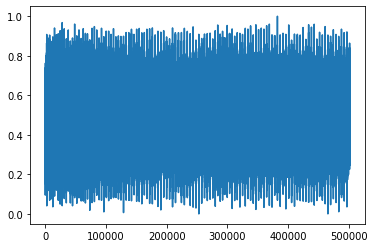

In [ ]:
df_training[target].plot()

In [ ]:
res = results['lgbm_slider20'][0].model.predict(df_validation[features]) #Normal

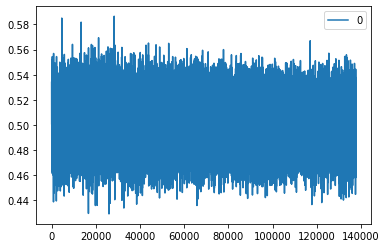

In [ ]:
pd.DataFrame(res).plot()

In [ ]:
results['lgbm_slider20'][0].model.predict(df_validation[features]) #FN

array([0.49764944, 0.4911359 , 0.49892449, ..., 0.492179  , 0.48661223,
       0.49113268])

##### XGB Ranker

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRanker
from sklearn.model_selection import cross_validate


#####################################################################
#####################################################################

space  = [
           #step 1 & 6
           Integer(2000, 5000, name='n_estimators', prior='uniform'), 
           Real(5**-3, 10**-1, name='learning_rate', prior='log-uniform'), 

           #step 2
           Integer(3, 10, name='max_depth', prior='uniform'),
           Integer(1, 10, name='min_child_weight', prior='uniform'),

           #step 3
           Real(1e-5, 6, name='gamma', prior='log-uniform'),

           #step 4
           Real(5e-2, .5, name='colsample_bytree', prior='uniform'),
           Real(5e-2, .5, name='subsample', prior='uniform'),
          
           #step 5
           Real(1, 100, name='reg_alpha', prior='log-uniform'),

]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    #print(params)

    #cria csv prov zerado aqui
    prov_scores =  pd.DataFrame(columns=['scores'])
    prov_scores.to_csv(file_name_prov, header=True, index=0)#df_training.era.unique


    res_dict = cross_validate(model, 
                               df_training[features], 
                               df_training[target], 
                               groups=df_training.era,
                               return_estimator=True,
                               #return_train_score=True,
                               scoring = scorer, 
                               n_jobs=-1,
                               cv=slider_grp)
    

    adj_sharpe_val = res_dict['test_score'].mean()
    preds_test = res_dict['estimator'][-1].predict(df_validation[features]).tolist()


    eras_score_test = metrics_era.numerai_score(df_validation[target], preds_test, df_validation)
    eras_score_cv = pd.read_csv(file_name_prov, index_col=0)
    

    eras_score_full = pd.concat([eras_score_cv.squeeze(), eras_score_test]).to_frame().T
    eras_score_full['hparam'] = '{}'.format(params)


    eras_score_full.to_csv(file_name, mode='a', header=False, index=False)
    return -adj_sharpe_val

#####################################################################
#####################################################################

class MyXGBRanker(XGBRanker, BaseEstimator, RegressorMixin):
    def fit(self, x, y):
        cdf = x.groupby('era').agg(['count'])
        group = cdf[cdf.columns[0]].values
        return super().fit(x[features], y, group=group)

    def predict(self, x):
        return super().predict(x[features])


print(str(scorer))
model =MyXGBRanker(tree_method = 'gpu_hist',
                    #n_estimators=2000,
                    #learning_rate=0.01,
                    #max_depth=5,
                    #colsample_bytree=0.1,
                    n_jobs=-1,
                    gpu_id=0)

file_name = 'era_scores_xgb_ranker_slider5.csv'
file_name_prov = 'prov_scores.csv'


#cria csv principal
cols = cols = group_ts_split.results_df_cols(slider_grp, df_training, df_validation)
preds_df =  pd.DataFrame(columns=cols)
preds_df.to_csv(file_name, header=True, index=False)


res_gp = dummy_minimize(objective, space, n_calls=200, verbose=1, random_state=54)

In [ ]:
from xgboost import XGBRanker
from sklearn.base import BaseEstimator, RegressorMixin

class MyXGBRanker(XGBRanker, BaseEstimator, RegressorMixin):
    def fit(self, x, y):
        cdf = x.groupby('era').agg(['count'])
        group = cdf[cdf.columns[0]].values
        return super().fit(x[features], y, group=group)

    def predict(self, x):
        return super().predict(x[features])


xgb_param_grid = {
        #step 1 & 6
        'n_estimators' : [4547], #Integer(3000, 6000, 'uniform'),
        'learning_rate' : [0.01], #Real(10**-3, 10**-1, "log-uniform"), 


        #step 2
        'max_depth' : [3], #Integer(3, 10, 'uniform'),
        'min_child_weight':[9], #Integer(8, 16, 'uniform'), 

        #step 3
        'gamma' : [0.00003253],# Real(1e-5, 6, 'log-uniform'),


        #step 4
        'subsample' : [1],# Real(1e-1, 1, 'uniform'),
        'colsample_bytree':[0.1553875313199311],# Real(1e-1, .5, 'uniform'), 

        #step 5
        'reg_alpha' : [50.20283749898673], #Real(1, 100, 'log-uniform'),

        
        #utils
        #'early_stopping_rounds' : [30],
        'tree_method' : ['gpu_hist'],#['gpu_hist'], 
        'gpu_id' : [0],

        
}


#gpu_params = {'updater':'', 'predictor':'cpu_predictor', 'tree_method':'hist'}
result = evaluation.evaluate_model_skopt(df_training[['era']+features], df_training[target],
                                          MyXGBRanker(), 'xgb_ranker',
                                          xgb_param_grid, 
                                          scorer, 
                                          n_jobs=-1, 
                                          n_iter=1, 
                                          cv_folds=cv_grp, 
                                          pipeline=None)

#result[0].model.get_booster().set_param(gpu_params)
results['xgb_ranker'] = result

#step 1: 0.0352
#step 2: 0.0460
#step 3: 0.0460
#step 4: 0.0457
#step 5: 0.0465
#step 6: 0.0480

#### Salvando os modelos (vanilla)

In [ ]:
model_name = [
              #"lr"
              #,"ridge"
              #,"omp"
              "xgb_slider20"
              #"lgbm_slider20"
              #"xgb_ranker"             
]

In [ ]:
results

{'xgb_slider20': (<train_model.TunedModel at 0x7f193ac25710>,
  'xgb_slider20',
  1.098899817320995,
  0.3196699989392253)}

In [ ]:
from joblib import dump, load

#Maior media, senao sera ultimo feito, 
#results = sorted(results, key=lambda x: x[2], reverse=True)


for name in model_name:
  #model = list(filter(lambda x: x[1] == name, results))[-1][0]
  dump(results[name][0], name + '-cv.pkl')

### Expanding 5-GRP

#### lineares

linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

lr_param_grid =  {
    'fit_intercept' : [True, False],
    'normalize' : [True, False],

}


result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'lr',
                                   lr_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=ts_grp, 
                                   pipeline=None)

results.append(result)

==> Starting K-fold cross validation for lr model, 501808 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.3s finished


==> Elapsed seconds: 35.859
Best lr model: LinearRegression(fit_intercept=False, normalize=True)
Best lr score (val): 0.9596




---



---



Ridge 

In [ ]:
from sklearn.linear_model import Ridge

ridge_param_grid =  {
    'fit_intercept' : [True, False],
    'normalize' : [True, False],
    'alpha' : Real(10**-1, 10**1, "log-uniform")

}


result = evaluation.evaluate_model(df_training[features], df_training[target],
                                          Ridge(), 'ridge',
                                          ridge_param_grid, 
                                          scorer, 
                                          n_iter=1, 
                                          cv_folds=ts_grp, 
                                          pipeline=None)

results['ridge'] = result

==> Starting K-fold cross validation for ridge model, 501808 examples
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


==> Elapsed seconds: 9.304
Best ridge model: Ridge(alpha=40)
Best ridge score (val): 0.7682




---



---



OMP

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import cross_validate


#####################################################################
#####################################################################

space  = [    
           Categorical([True, False], name='fit_intercept'),
           Categorical([True, False], name='normalize'),
           Integer(10, len(features), name='n_nonzero_coefs', prior='uniform')
]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    #print(params)

    #cria csv prov zerado aqui
    prov_scores =  pd.DataFrame(columns=['scores'])
    prov_scores.to_csv(file_name_prov, header=True, index=0)#df_training.era.unique


    res_dict = cross_validate(model, 
                               df_training[features], 
                               df_training[target], 
                               groups=df_training.era,
                               return_estimator=True,
                               #return_train_score=True,
                               scoring = scorer, 
                               n_jobs=-1,
                               cv=ts_grp)
    

    adj_sharpe_val = res_dict['test_score'].mean()
    preds_test = res_dict['estimator'][-1].predict(df_validation[features]).tolist()


    eras_score_test = metrics_era.numerai_score(df_validation[target], preds_test, df_validation)
    eras_score_cv = pd.read_csv(file_name_prov, index_col=0)
    

    eras_score_full = pd.concat([eras_score_cv.squeeze(), eras_score_test]).to_frame().T
    eras_score_full['hparam'] = '{}'.format(params)


    eras_score_full.to_csv(file_name, mode='a', header=False, index=False)
    return -adj_sharpe_val

#####################################################################
#####################################################################


print(str(scorer))
model =OrthogonalMatchingPursuit()

file_name = 'era_scores_omp_exp20.csv'
file_name_prov = 'prov_scores.csv'


#cria csv principal
cols = cols = group_ts_split.results_df_cols(ts_grp, df_training, df_validation)
preds_df =  pd.DataFrame(columns=cols)
preds_df.to_csv(file_name, header=True, index=False)


res_gp = dummy_minimize(objective, space, n_calls=200, verbose=1, random_state=34)

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit

omp_param_grid =  {
    'fit_intercept' : [True],
    'normalize' : [False],
    'n_nonzero_coefs' : [92],#Integer(1, len(features), 'uniform')

}


result = evaluation.evaluate_model_skopt(df_training[features], df_training[target],
                                   OrthogonalMatchingPursuit(), 'omp_exp20',
                                   omp_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=ts_grp, 
                                   pipeline=None)


results['omp_exp20'] = result

==> Starting K-fold cross validation for omp_exp20 model, 501808 examples
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


==> Elapsed seconds: 11.128
Best omp_exp20 model: OrthogonalMatchingPursuit(n_nonzero_coefs=92, normalize=False)
Best omp_exp20 score (val): 0.7894




---



---



#### GBM

##### xgboost vanilla

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate


#####################################################################
#####################################################################

space  = [
           #step 1 & 6
           Integer(2000, 5000, name='n_estimators', prior='uniform'), 
           Real(5**-3, 10**-1, name='learning_rate', prior='log-uniform'), 

           #step 2
           Integer(3, 10, name='max_depth', prior='uniform'),
           Integer(1, 10, name='min_child_weight', prior='uniform'),

           #step 3
           Real(1e-5, 6, name='gamma', prior='log-uniform'),

           #step 4
           Real(5e-2, .5, name='colsample_bytree', prior='uniform'),
           Real(5e-2, .5, name='subsample', prior='uniform'),
          
           #step 5
           Real(1, 100, name='reg_alpha', prior='log-uniform'),

]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    #print(params)

    #cria csv prov zerado aqui
    prov_scores =  pd.DataFrame(columns=['scores'])
    prov_scores.to_csv(file_name_prov, header=True, index=0)#df_training.era.unique


    res_dict = cross_validate(model, 
                               df_training[features], 
                               df_training[target], 
                               groups=df_training.era,
                               return_estimator=True,
                               #return_train_score=True,
                               scoring = scorer, 
                               n_jobs=-1,
                               cv=ts_grp)
    

    adj_sharpe_val = res_dict['test_score'].mean()
    preds_test = res_dict['estimator'][-1].predict(df_validation[features]).tolist()


    eras_score_test = metrics_era.numerai_score(df_validation[target], preds_test, df_validation)
    eras_score_cv = pd.read_csv(file_name_prov, index_col=0)
    

    eras_score_full = pd.concat([eras_score_cv.squeeze(), eras_score_test]).to_frame().T
    eras_score_full['hparam'] = '{}'.format(params)


    eras_score_full.to_csv(file_name, mode='a', header=False, index=False)
    return -adj_sharpe_val

#####################################################################
#####################################################################

print(str(scorer))
model =XGBRegressor(tree_method = 'gpu_hist',
                    #n_estimators=2000,
                    #learning_rate=0.01,
                    #max_depth=5,
                    #colsample_bytree=0.1,
                    n_jobs=-1,
                    gpu_id=0)

file_name = 'era_scores_xgb_exp20.csv'
file_name_prov = 'prov_scores.csv'


#cria csv principal
cols = group_ts_split.results_df_cols(ts_grp, df_training, df_validation)
preds_df =  pd.DataFrame(columns=cols)
preds_df.to_csv(file_name, header=True, index=False)


res_gp = dummy_minimize(objective, space, n_calls=200, verbose=1, random_state=154)

In [ ]:
from google.colab import files
files.download("/content/era_scores_xgb_exp20.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from xgboost import XGBRegressor
#example scripts
#XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)



b={'n_estimators': 2851, 
 'learning_rate': 0.012559878784975307, 
 'max_depth': 4, 
 'min_child_weight': 7, 
 'gamma': 0.17985836491648036, 
 'colsample_bytree': 0.2784204086247318, 
 'subsample': 0.33994697676863767, 
 'reg_alpha': 2.6691509215708877}


xgb_param_grid = {
        #step 1 & 6
        'n_estimators' : [2851],#Integer(1000, 5000, 'uniform'),
        'learning_rate' : [0.012559878784975307],#Real(10**-3, 10**-1, "log-uniform"),


        #step 2
        'max_depth' : [4],#Integer(3, 10, 'uniform'),
        'min_child_weight':[7],# Integer(1, 10, 'uniform'),

        #step 3
        'gamma' : [0.17985836491648036],#Real(1e-5, 6, 'log-uniform'),


        #step 4
        'subsample' : [0.33994697676863767],#Real(1e-1, 1, 'uniform'),
        'colsample_bytree':[0.2784204086247318], #Real(1e-1, .5, 'uniform'), 

        #step 5
        'reg_alpha' : [2.6691509215708877],#Real(1, 100, 'log-uniform'),


        #utils
        'objective': ["reg:squarederror"],
        #'early_stopping_rounds' : [30],
        'tree_method' : ['gpu_hist'],#['gpu_hist'], 
        'gpu_id' : [0],
        
}


gpu_params = { 'predictor':'cpu_predictor', 'tree_method':'hist'}
result = evaluation.evaluate_model(df_training[features], df_training[target],
                                          XGBRegressor(), 'xgb_slider20',
                                          xgb_param_grid, 
                                          scorer, 
                                          n_jobs=-1, 
                                          n_iter=1, 
                                          cv_folds=ts_grp, 
                                          pipeline=None)


result[0].model.get_booster().set_param(gpu_params)
results['xgb_slider20'] = result

==> Starting K-fold cross validation for xgb_slider20 model, 501808 examples
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


==> Elapsed seconds: 132.407
Best xgb_slider20 model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2784204086247318,
             gamma=0.17985836491648036, gpu_id=0, importance_type='gain',
             interaction_constraints='', learning_rate=0.012559878784975307,
             max_delta_step=0, max_depth=4, min_child_weight=7, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=2851, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=2.6691509215708877, reg_lambda=1, scale_pos_weight=1,
             subsample=0.33994697676863767, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)
Best xgb_slider20 score (val): 0.7625


##### lgbm vanilla

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate


#####################################################################
#####################################################################

space  = [
           #step 1&5
           Integer(1000, 4000, name='n_estimators', prior='uniform'),
           Real(5**-3, 10**-1,  name='learning_rate', prior='log-uniform'),

           #step 2
           Integer(50, 250, name='num_leaves', prior='uniform'),
           Integer(100, 2000, name='min_data_in_leaf', prior='uniform'),
           Integer(3, 30, name='max_depth', prior='uniform'),

           #step 3
           Real(5e-2, 0.5, name='colsample_bytree', prior='uniform'),
           Real(5e-2, 0.5, name='subsample', prior='uniform'),

           #step 4
           Real(10**-2, 1.0, name='reg_lambda', prior='log-uniform'),
]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    #print(params)

    #cria csv prov zerado aqui
    prov_scores =  pd.DataFrame(columns=['scores'])
    prov_scores.to_csv(file_name_prov, header=True, index=0)#df_training.era.unique


    res_dict = cross_validate(model, 
                               df_training[features], 
                               df_training[target], 
                               groups=df_training.era,
                               return_estimator=True,
                               #return_train_score=True,
                               scoring = scorer, 
                               n_jobs=-1,
                               cv=ts_grp)
    

    adj_sharpe_val = res_dict['test_score'].mean()
    preds_test = res_dict['estimator'][-1].predict(df_validation[features]).tolist()


    eras_score_test = metrics_era.numerai_score(df_validation[target], preds_test, df_validation)
    eras_score_cv = pd.read_csv(file_name_prov, index_col=0)
    

    eras_score_full = pd.concat([eras_score_cv.squeeze(), eras_score_test]).to_frame().T
    eras_score_full['hparam'] = '{}'.format(params)


    eras_score_full.to_csv(file_name, mode='a', header=False, index=False)
    return -adj_sharpe_val

#####################################################################
#####################################################################

print(str(scorer))
model =LGBMRegressor(device_type = 'gpu',
                    #n_estimators=2000,
                    #learning_rate=0.01,
                    #max_depth=5,
                    #colsample_bytree=0.1,
                    n_jobs=-1)

file_name = 'era_scores_lgbm_exp5.csv'
file_name_prov = 'prov_scores.csv'


#cria csv principal
cols = group_ts_split.results_df_cols(slider_grp, df_training, df_validation)
preds_df = pd.DataFrame(columns=cols)
preds_df.to_csv(file_name, header=True, index=False)


res_gp = dummy_minimize(objective, space, n_calls=200, verbose=1, random_state=54)

In [ ]:
from lightgbm import LGBMRegressor
#LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1, num_leaves=32)


b={'n_estimators': 2012, 
 'learning_rate': 0.008053288987896146, 
 'num_leaves': 104, 
 'min_data_in_leaf': 1877, 
 'max_depth': 19, 
 'colsample_bytree': 0.2838163562602001, 
 'subsample': 0.2265121308916066, 
 'reg_lambda': 0.4781007325965136}

lgbm_param_grid = {
    

    #step 1 & 6
    'n_estimators' : [2012],#Integer(500, 4000, 'uniform'), #[623]
    'learning_rate' :[0.008053288987896146],# Real(10**-3, 10**-1, "log-uniform"),  #[0.1]


    #step 2
    'num_leaves': [104], #Integer(50, 250, "uniform"), #
    'min_data_in_leaf' : [1877],# Integer(100, 2000, 'uniform'), #
    'max_depth' : [19], #Integer(3, 30, 'uniform'), #
    

    #step 3
    #'bagging_fraction' : [0.3195476883574932],#Real(1e-1, 1, 'uniform'), #
    #'bagging_temperature': [0.5776416670125987],# Real(1e-1, 1.0, 'uniform'), #
    
    #step 4
    'colsample_bytree': [0.2838163562602001], #Real(1e-1, .5, 'uniform'), #
    'subsample': [0.2265121308916066], #Real(1e-1, 1.0, 'uniform'), #

    #step 5
    'reg_lambda': [0.4781007325965136], #Real(10**-2, 1, "log-uniform"), #


    #utils
    'boosting_type': ['goss'],
    'device_type' : ['gpu']

}



gpu_params = {'device_type':'cpu'}
result = evaluation.evaluate_model(df_training[features], df_training[target],
                                          LGBMRegressor(), 'lgbm_cv40',
                                          lgbm_param_grid, 
                                          scorer, 
                                          n_iter=1, 
                                          cv_folds=cv_grp, 
                                          pipeline=None)


result[0].model.set_params(**gpu_params)
results['lgbm_cv40'] = result

==> Starting K-fold cross validation for lgbm_exp20 model, 501808 examples
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: ignored

##### XGB Ranker

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize, dummy_minimize
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRanker
from sklearn.model_selection import cross_validate


#####################################################################
#####################################################################

space  = [
           #step 1 & 6
           Integer(2000, 5000, name='n_estimators', prior='uniform'), 
           Real(5**-3, 10**-1, name='learning_rate', prior='log-uniform'), 

           #step 2
           Integer(3, 10, name='max_depth', prior='uniform'),
           Integer(1, 10, name='min_child_weight', prior='uniform'),

           #step 3
           Real(1e-5, 6, name='gamma', prior='log-uniform'),

           #step 4
           Real(5e-2, .5, name='colsample_bytree', prior='uniform'),
           Real(5e-2, .5, name='subsample', prior='uniform'),
          
           #step 5
           Real(1, 100, name='reg_alpha', prior='log-uniform'),

]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    #print(params)

    #cria csv prov zerado aqui
    prov_scores =  pd.DataFrame(columns=['scores'])
    prov_scores.to_csv(file_name_prov, header=True, index=0)#df_training.era.unique


    res_dict = cross_validate(model, 
                               df_training[features], 
                               df_training[target], 
                               groups=df_training.era,
                               return_estimator=True,
                               #return_train_score=True,
                               scoring = scorer, 
                               n_jobs=-1,
                               cv=ts_grp)
    

    adj_sharpe_val = res_dict['test_score'].mean()
    preds_test = res_dict['estimator'][-1].predict(df_validation[features]).tolist()


    eras_score_test = metrics_era.numerai_score(df_validation[target], preds_test, df_validation)
    eras_score_cv = pd.read_csv(file_name_prov, index_col=0)
    

    eras_score_full = pd.concat([eras_score_cv.squeeze(), eras_score_test]).to_frame().T
    eras_score_full['hparam'] = '{}'.format(params)


    eras_score_full.to_csv(file_name, mode='a', header=False, index=False)
    return -adj_sharpe_val

#####################################################################
#####################################################################


print(str(scorer))
model =XGBRegressor(tree_method = 'gpu_hist',
                    objective='rank:pairwise',
                    #n_estimators=2000,
                    #learning_rate=0.01,
                    #max_depth=5,
                    #colsample_bytree=0.1,
                    n_jobs=-1,
                    gpu_id=0)

file_name = 'era_scores_xgb_ranker_exp20.csv'
file_name_prov = 'prov_scores.csv'


#cria csv principal
cols = cols = group_ts_split.results_df_cols(ts_grp, df_training, df_validation)
preds_df =  pd.DataFrame(columns=cols)
preds_df.to_csv(file_name, header=True, index=False)


res_gp = dummy_minimize(objective, space, n_calls=200, verbose=1, random_state=54)

In [ ]:
from google.colab import files
files.download("/content/era_scores_xgb_ranker_exp20.csv")

In [ ]:
from xgboost import XGBRanker
from sklearn.base import BaseEstimator, RegressorMixin

class MyXGBRanker(XGBRanker, BaseEstimator, RegressorMixin):
    def fit(self, x, y):
        cdf = x.groupby('era').agg(['count'])
        group = cdf[cdf.columns[0]].values
        return super().fit(x[features], y, group=group)

    def predict(self, x):
        return super().predict(x[features])


xgb_param_grid = {
        #step 1 & 6
        'n_estimators' : [4547], #Integer(3000, 6000, 'uniform'),
        'learning_rate' : [0.01], #Real(10**-3, 10**-1, "log-uniform"), 


        #step 2
        'max_depth' : [3], #Integer(3, 10, 'uniform'),
        'min_child_weight':[9], #Integer(8, 16, 'uniform'), 

        #step 3
        'gamma' : [0.00003253],# Real(1e-5, 6, 'log-uniform'),


        #step 4
        'subsample' : [1],# Real(1e-1, 1, 'uniform'),
        'colsample_bytree':[0.1553875313199311],# Real(1e-1, .5, 'uniform'), 

        #step 5
        'reg_alpha' : [50.20283749898673], #Real(1, 100, 'log-uniform'),

        
        #utils
        #'early_stopping_rounds' : [30],
        'tree_method' : ['gpu_hist'],#['gpu_hist'], 
        'gpu_id' : [0],

        
}


#gpu_params = {'updater':'', 'predictor':'cpu_predictor', 'tree_method':'hist'}
result = evaluation.evaluate_model_skopt(df_training[['era']+features], df_training[target],
                                          MyXGBRanker(), 'xgb_ranker',
                                          xgb_param_grid, 
                                          scorer, 
                                          n_jobs=-1, 
                                          n_iter=1, 
                                          cv_folds=ts_grp, 
                                          pipeline=None)

#result[0].model.get_booster().set_param(gpu_params)
results['xgb_ranker'] = result

#step 1: 0.0352
#step 2: 0.0460
#step 3: 0.0460
#step 4: 0.0457
#step 5: 0.0465
#step 6: 0.0480

#### Salvando os modelos (vanilla)

In [ ]:
model_name = [
              #"lr"
              #"ridge"
              #"omp_exp20"
              #"xgb_exp20"
              "lgbm_exp20"
              #"xgb_ranker"             
]

In [ ]:
results

{'xgb_slider20': (<train_model.TunedModel at 0x7f43fd1cd6a0>,
  'xgb_slider20',
  0.7624803868757556,
  0.38353656314999585)}

In [ ]:
from joblib import dump, load

#Maior media, senao sera ultimo feito, 
#results = sorted(results, key=lambda x: x[2], reverse=True)


for name in model_name:
  #model = list(filter(lambda x: x[1] == name, results))[-1][0]
  dump(results[name][0], name + '-cv.pkl')

## 6. FN Transforms (after)

### results

In [27]:
%%time
path = '/content/dissertacao/reports/predicoes_validacao/'
models_nr = ['ex_preds', 'ex_FN100', 'nr__rio', 'nr__sao_paulo', 'nr__medellin','nr__guadalajara']


preds_nr, feat_corrs_nr = dict(), dict()
era_scores_nr, df_metrics_nr = dict(), dict()


for model in models_nr[0:]:
    
    #predicoes val1 & val2
    print("creating predictions to:", model)
    
    if (model=='ex_preds' or model=='ex_FN100'): pred_path = github_url
    else: pred_path = path
    preds_nr[model]=pd.read_csv(pred_path+model+'_preds_test.csv',index_col='id').values.reshape(1,-1)[0]
    

    #salvando as metricas
    era_scores_nr[model], df_metrics_nr[model], feat_corrs_nr[model] = \
                        metrics.submission_metrics(df_validation, preds_nr[model], model, False)   





#dict to dataframe
df_preds_nr = pd.DataFrame.from_dict(preds_nr)
df_era_scores_nr = pd.DataFrame.from_dict(era_scores_nr)
df_feat_corrs_nr = pd.DataFrame.from_dict(feat_corrs_nr)
df_metrics_cons_nr = metrics.metrics_consolidated(df_metrics_nr)

creating predictions to: ex_preds
creating predictions to: ex_FN100
creating predictions to: nr__rio
creating predictions to: nr__sao_paulo
creating predictions to: nr__medellin
creating predictions to: nr__guadalajara
CPU times: user 2min 40s, sys: 47.5 s, total: 3min 28s
Wall time: 2min 2s


In [28]:
#print("Menor é melhor:", min_cols)
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,models_nr[0:]]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,ex_FN100,nr__rio,nr__sao_paulo,nr__medellin,nr__guadalajara
Metrica,,,,,,
Validation_Sharpe,0.9757,1.2648,1.2787,1.2194,1.3584,1.4355
Validation_Mean,0.0266,0.0234,0.0235,0.0238,0.0211,0.0284
Feat_neutral_mean,0.0215,0.0226,0.0214,0.0196,0.0204,0.0194
Validation_SD,0.0272,0.0185,0.0184,0.0195,0.0156,0.0198
Feat_exp_max,0.2694,0.0146,0.0299,0.0614,0.0084,0.1945
Max_Drawdown,-0.0651,-0.0270,-0.0373,-0.0417,-0.0203,-0.0199
corr_plus_mmc_sharpe,0.9757,0.9910,1.0776,1.0050,1.0919,1.5257
val_mmc_mean,0.0000,0.0055,0.0075,0.0041,0.0062,0.0076
corr_with_example_preds,1.0000,0.6078,0.5091,0.6810,0.4869,0.6920


### FN After (Target)

In [25]:
from sklearn.preprocessing import MinMaxScaler 
def eras_score_fn(y_true, y_pred):
    target = 'target_fn'

    #create y_true as df
    y_true = y_true.to_frame(name=target)
    y_true = y_true.join(df_training['era'])

    #create y_pred as df
    preds_df = pd.DataFrame(y_pred, index = y_true.index, columns=['preds'])
    preds_df = preds_df.join(df_training['era'])
    era_scores = pd.Series(index=y_true['era'].unique())

    for era in y_true['era'].unique():
        era_df = y_true[y_true['era'] == era]
        era_preds = preds_df[preds_df['era'] == era]
        era_scores[era] = np.corrcoef(era_df[target], 
                                      era_preds['preds'].rank(pct=True, method="first"))[0,1]

    
    results = era_scores.to_frame()
    #results.to_csv(file_name_prov, mode='a', header=False, index=True)
    return era_scores


def validation_mean_(y_true, y_pred):
  era_scores = eras_score(y_true, y_pred)
  return np.mean(era_scores)


def annual_sharpe(x):
    return ((np.mean(x) -0.010415154) /np.std(x, ddof=1)) #* np.sqrt(12) 

from scipy.stats import skew, kurtosis, sem, gmean
def adj_sharpe_pre_(y_true, y_pred):
  x = eras_score_fn(y_true, y_pred)
  return annual_sharpe(x) * (1 + ((skew(x) / 6) * annual_sharpe(x)) - \
                             ((kurtosis(x) - 0) / 24) * (annual_sharpe(x) ** 2)) 




scorer = make_scorer(adj_sharpe_pre_)

In [94]:
def _neutralize(df, columns, by, ml_model, proportion=1.0): #['preds'], features,
    scores = df[columns] #preds
    exposures = df[by].values #features
    ml_model[0].fit(exposures, scores.values.reshape(1,-1)[0])
    neutr_preds = pd.DataFrame(ml_model[0].predict(exposures), index=df.index, columns=columns)
    #exposures.dot(np.linalg.pinv(exposures).dot(scores))    

    
    if ml_model[1] != None:
        ml_model[1].fit(exposures, scores.values.reshape(1,-1)[0])
        neutr_preds2 = pd.DataFrame(ml_model[1].predict(exposures), index=df.index, columns=columns)

    else: neutr_preds2 = 0# np.zeros(len(scores))


    scores = scores - ((proportion[0] * neutr_preds) + ((1-proportion[1]) * neutr_preds2))



    #scores = scores - proportion * neutr_preds
    return scores / scores.std()



def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)


def normalize_and_neutralize(df, columns, by, ml_model, proportion):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, ml_model, proportion)
    return df[columns]



def preds_neutralized(df, columns, by, ml_model, proportion):

    for group_by in by:
      feat_by = [c for c in df if c.startswith('feature_'+group_by)]
      preds_neutr = df.groupby("era").apply( lambda x: normalize_and_neutralize(x, columns, feat_by, ml_model, proportion))
      preds_neutr_after = MinMaxScaler().fit_transform(preds_neutr).reshape(1,-1)[0]

    return preds_neutr_after

def preds_neutralized_old(df, columns, by, ml_model, proportion):

    preds_neutr = df.groupby("era").apply( lambda x: normalize_and_neutralize(x, columns, by, ml_model, proportion))

    preds_neutr = MinMaxScaler().fit_transform(preds_neutr).reshape(1,-1)[0]

    return preds_neutr
    

#### comecando stacking

In [31]:
pkl_path = '/content/dissertacao/models/nr_models/'

In [43]:
models = dict()
models['nr__medellin'] = load(pkl_path + 'nr__medellin' + '-cv.pkl')


In [44]:
#cv predict
from sklearn.model_selection import cross_val_predict

preds_cv = cross_val_predict(models['nr__medellin'].model, 
                             df_training[features], 
                             df_training['target'], 
                             cv=cv_grp)

[LightGBM] [Warning] min_data_in_leaf is set=1395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1395
[LightGBM] [Warning] min_data_in_leaf is set=1395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1395
[LightGBM] [Warning] min_data_in_leaf is set=1395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1395


In [46]:
%%time

from joblib import dump, load
path = '/content/'

#models, res_cv, preds = dict(), dict(), dict()
models_nr = ['ex_preds', 'nr__medellin']#, 'lgbm_slider20', 'lgbm_cv40']

for model in models_nr[1:]:
    #load model complete pipe
    print("creating predictions to:", model)
    #models[model] = load(file_path + model + '-cv.pkl')
    #preds[model] = models[model].model.predict(df_validation[features])

    # predictions must have an `id` column and a `prediction_kazutsugi` column
    predictions_df = df_training["id"].to_frame()
    predictions_df[model] = preds_cv
    predictions_df.to_csv(path+model +"_preds_test.csv", index=False)


creating predictions to: nr__medellin
CPU times: user 1.13 s, sys: 23 ms, total: 1.16 s
Wall time: 1.16 s


In [ ]:
features

terminando stacking

#### comecando l2 target

In [81]:
import torch
from torch.nn import Linear
from torch.nn import Sequential
from torch.functional import F



def exposures(x, y):
    x = x - x.mean(dim=0)
    x = x / x.norm(dim=0)
    y = y - y.mean(dim=0)
    y = y / y.norm(dim=0)
    return torch.matmul(x.T, y)



def reduce_exposure(prediction, features, max_exp):
    # linear model of features that will be used to partially neutralize predictions
    lin = Linear(features.shape[1],  1, bias=False)
    lin.weight.data.fill_(0.)
    model = Sequential(lin)
    optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4)

    feats = torch.tensor(np.float32(features)-.5)
    pred = torch.tensor(np.float32(prediction))
    start_exp = exposures(feats, pred[:,None])

    # set target exposure for each feature to be <= current exposure
    # if current exposure is less than max_exp, or <= max_exp if  
    # current exposure is > max_exp
    targ_exp = torch.clamp(start_exp, -max_exp, max_exp)

    for i in range(100000):#100000
        optimizer.zero_grad()
        # calculate feature exposures of current linear neutralization
        exps = exposures(feats, pred[:,None]-model(feats))

        # loss is positive when any exposures exceed their target
        loss = (F.relu(F.relu(exps)-F.relu(targ_exp)) + F.relu(F.relu(-exps)-F.relu(-targ_exp))).sum()
        #print(loss)
        print(f'       loss: {loss:0.7f}', end='\r')

        if loss < 1e-7: #7
            #print('11111')
            neutralizer = [p.detach().numpy() for p in model.parameters()]
            neutralized_pred = pred[:,None]-model(feats)
            break
        loss.backward()
        optimizer.step()
    return neutralized_pred, neutralizer



def reduce_all_exposures(df, column, neutralizers=[],
                                     normalize=True,
                                     gaussianize=True,
                                     era_col="era",
                                     max_exp=0.05):
  
    #print(max_exp)
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        if (u % 10==0):
          print(u, '\r') #print era
        df_era = df[df[era_col] == u]
        scores = df_era[column].values #preds
        exposure_values = df_era[neutralizers].values #features
        
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                if gaussianize:
                    x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2)[0]

        scores, neut = reduce_exposure(scores, exposure_values, max_exp)

        scores /= scores.std()

        computed.append(scores.detach().numpy())

    return pd.DataFrame(np.concatenate(computed), columns=column, index=df.index)


def neutralize_by_threshold(df, column, neutralizers=[],
                                     normalize=True,
                                     gaussianize=True,
                                     era_col="era",
                                     max_exp=0.05):
  
  
  data_rfe = reduce_all_exposures(df, column, neutralizers, 
                                  normalize, gaussianize, 
                                  era_col="era", 
                                  max_exp=0.05)
  
  df[column] = data_rfe[column]
  df[column]  -= df[column] .min()
  df[column]  /= df[column] .max()

  return df[column]



In [95]:
from sklearn.linear_model import LinearRegression, Ridge

def get_topk(df, preds, k):
    _, _, feat_exp = metrics.feature_exposure_old(df, preds)
    k_exposed = feat_exp[feat_exp.abs() > feat_exp.abs().quantile(1-k)].index
    return k_exposed



def get_groups(*g):
  return g

def passtrhough_(*r):
    return r[2]


l2_strategy_dict = {
    
   'medellin_tr5': {'pkl': 'nr__medellin', 
                 'func': passtrhough_, 
                 #'columns': ['preds'], 
                 'by': neutralize_by_threshold , 
                 'model': [LinearRegression(fit_intercept=False), None],
                 'factor': [0.8, 0]
                 },  

   'rio_top10': {'pkl': 'nr__rio', 
                 'func': preds_neutralized_old, 
                 #'columns': ['preds'], 
                 'by': get_topk, 
                 'model': [LinearRegression(fit_intercept=False), None], 
                 'factor': [0.8, 0]
                 },


  'medellin_group': {'pkl': 'nr__medellin', 
                 'func': preds_neutralized, 
                 #'columns': ['preds'], 
                 'by': get_groups , 
                 'model': [LinearRegression(fit_intercept=False), None],  
                 'factor': [0.8, 0]
                 }, 


  'xgb_metric': {'pkl': 'xgb_slider20_MetricFN', 
                 'func': preds_neutralized, 
                 #'columns': ['preds'], 
                 'by': get_groups, 
                 'model': [LinearRegression(fit_intercept=False), None], 
                 'factor': [0.8, 0]
                 }, 


}




In [83]:
#df_training = df_training[df_training.era<=4]

In [ ]:
%%time

path = '/content/dissertacao/reports/predicoes_validacao/'
pkl_path = '/content/dissertacao/models/san_francisco/'


features = [c for c in df_training if c.startswith("feature")]
l2_strategy = l2_strategy_dict

preds_nr, feat_corrs_nr = dict(), dict()
era_scores_nr, df_metrics_nr = dict(), dict()
models = dict()

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
ml_model = [LinearRegression(fit_intercept=False), None]

for model, l2_params in l2_strategy.items():
    
    #if model == 'medellin_tr5': continue

    #predicoes to df_training
    print("\ncreating predictions to:", model)
    models[model] = load(pkl_path + l2_params['pkl'] + '-cv.pkl')
    #df_training['preds_'+model] = models[model].model.predict(df_training[features])
    
    df_training['preds_'+model] = cross_val_predict(models[model].model, 
                                                    df_training[features], 
                                                    df_training['target'], 
                                                    cv=cv_grp)#

    if model=='rio_top10': params = [df_training, df_training['preds_'+model], .1]
    if model=='medellin_group': params = ['constitution', 'strength', 'dexterity', 'intelligence']
    if model=='xgb_metric': params = ['constitution', 'strength', 'intelligence']
    if model=='medellin_tr5': params = [df_training,['preds_'+model],features,True,True,"era",0.06]



    fn_feat = l2_params['by'](*params)
    df_training['target_fn_'+model]=l2_params['func'](df_training,['preds_'+model],
                                                      fn_feat,
                                                      ml_model,
                                                      [0.8,0])




creating predictions to: medellin_tr5
[LightGBM] [Warning] min_data_in_leaf is set=1395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1395
[LightGBM] [Warning] min_data_in_leaf is set=1395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1395
[LightGBM] [Warning] min_data_in_leaf is set=1395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1395
10 
20 
20 
30 
30 


In [ ]:
1

In [ ]:
anti = [c for c in df_training if not c.startswith("feature")]
df_training[anti].shape

In [ ]:
df_training[anti].to_csv('df_train_l1_light.csv', index=False)

#from google.colab import files
#files.download("/content/df_train_l1_light.csv")

In [59]:
#df_train_l1 = pd.read_csv('/content/df_train_l1_light.csv')
#df_train_l1.tail(20)

In [ ]:
df_training.tail(10)

In [ ]:
%%time

models = dict()
models_l2 = list()

pkl_path = '/content/dissertacao/models/san_francisco/'
l2_strategy = l2_strategy_dict

from sklearn.linear_model import LinearRegression
ml_model = [LinearRegression(fit_intercept=False), None]
features = [c for c in df_training if c.startswith("feature")]



for model, l2_params in l2_strategy.items():

    #load model complete pipe
    #if model == 'medellin_tr5': continue
    print("\ncreating predictions to:", model)
    models[model] = load(pkl_path + l2_params['pkl'] + '-cv.pkl')


    for model_l2, l2_params in l2_strategy.items():
      #if model_l2 == 'medellin_tr5': continue
      if model_l2 != 'xgb_metric': continue
      

      print("creating predictions to:", model+'_'+model_l2)
      models[model].model.fit(df_training[features], df_train_l1['target_fn_'+model])

     
      df_validation[model+'_'+model_l2] = models[model].model.predict(df_validation[features])
      models_l2.append(model+'_'+model_l2)



    if model=='rio_top10': params = [df_validation, df_validation[model+'_'+model_l2], .1]
    if model=='medellin_group': params = ['constitution', 'strength', 'dexterity', 'intelligence']
    if model=='xgb_metric': params = ['constitution', 'strength', 'intelligence']
    if model=='medellin_tr5': params = [df_validation,[model+'_'+model_l2],features,True,True,"era",0.06]



    fn_feat = l2_params['by'](*params)
    df_validation['target_fn_'+model]=l2_params['func'](df_validation,['preds_'+model],
                                                      fn_feat,ml_model,[0.8,0])



In [41]:
l2_strategy = l2_strategy_dict

if model=='rio_top10': params = [df_validation, df_validation[model+'_'+model_l2], .1]
if model=='medellin_group': params = ['constitution', 'strength', 'dexterity', 'intelligence']
if model=='medellin_group': params = ['']
if model=='medellin_tr5': params = [df_validation,[model+'_'+model_l2],features,True,True,"era",0.06]



In [ ]:
fn_feat

In [42]:
fn_feat = l2_params['by'](*params)
df_validation['target_fn_'+model]=l2_params['func'](df_validation,['preds_'+model],
                                                      fn_feat,ml_model,[0.8,0])

UFuncTypeError: ignored

In [69]:
df_validation.tail()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target,rio_top10_rio_top10,rio_top10_medellin_group,rio_top10_xgb_metric,medellin_group_rio_top10,medellin_group_medellin_group,medellin_group_xgb_metric,xgb_metric_rio_top10,xgb_metric_medellin_group,xgb_metric_xgb_metric
0,n0003aa52cab36c2,121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25,0.4491,0.4502,0.4566,0.5167,0.5123,0.5152,0.4678,0.4678,0.4678
1,n000920ed083903f,121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50,0.4597,0.4560,0.4573,0.4428,0.4385,0.4385,0.4072,0.4072,0.4072
2,n0038e640522c4a6,121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00,0.5984,0.5997,0.5973,0.5662,0.5710,0.5662,0.5414,0.5414,0.5414
3,n004ac94a87dc54b,121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50,0.5130,0.5130,0.5139,0.5872,0.5891,0.5913,0.5664,0.5664,0.5664
4,n0052fe97ea0c05f,121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75,0.5247,0.5234,0.5265,0.5032,0.5019,0.5007,0.4612,0.4612,0.4612


In [76]:
df_validation[anti].to_csv('df_val_l2_light.csv', index=False)

In [75]:
from google.colab import files
files.download("/content/df_val_l2_light.csv")

,id,era,data_type,target,rio_top10_rio_top10,rio_top10_medellin_group,rio_top10_xgb_metric,medellin_group_rio_top10,medellin_group_medellin_group,medellin_group_xgb_metric,xgb_metric_rio_top10,xgb_metric_medellin_group,xgb_metric_xgb_metric,preds,neutral_sub
0,n0003aa52cab36c2,121,validation,0.25,0.4998,0.4975,0.5105,0.5167,0.5123,0.5152,0.4678,0.4678,0.4678,0.5105,0.1384
1,n000920ed083903f,121,validation,0.50,0.4585,0.4504,0.4494,0.4428,0.4385,0.4385,0.4072,0.4072,0.4072,0.4494,-0.9440
2,n0038e640522c4a6,121,validation,1.00,0.5637,0.5593,0.5492,0.5662,0.5710,0.5662,0.5414,0.5414,0.5414,0.5492,-0.2240
3,n004ac94a87dc54b,121,validation,0.50,0.5987,0.5992,0.5936,0.5872,0.5891,0.5913,0.5664,0.5664,0.5664,0.5936,1.6673
4,n0052fe97ea0c05f,121,validation,0.75,0.5920,0.5925,0.5891,0.5032,0.5019,0.5007,0.4612,0.4612,0.4612,0.5891,0.3566


In [86]:
%%time
path = '/content/dissertacao/reports/predicoes_validacao/raw/'
models_nr = ['ex_preds', 'nr__rio_rio', 'nr__rio_med']#, 'nr__medellin', 'nr__rio' ,'preds']#, 'preds_fn_min', 'preds_fn_obj']


preds_nr, feat_corrs_nr = dict(), dict()
era_scores_nr, df_metrics_nr = dict(), dict()


for model in models_l2:
    
    #predicoes val1 & val2
    print("creating predictions to:", model)
    #preds_nr[model]= df_validation[model].values
    
    #load model complete pipe
    #print("creating predictions to:", model)
    #models[model] = load(file_path + model + '-cv.pkl')
    #preds[model] = models[model].model.predict(df_validation[features])
    #df_validation['preds']=  pd.read_csv(path+model+'_preds_test.csv', index_col='id').values.reshape(1,-1)[0]


    #preds neutralized after
    #preds_nr[model] = neutralize.preds_neutralized(df_validation, 
                                                   #[model],
                                                   #fn_strategy['nr__guadalajara']['columns'], 
                                                   #fn_strategy['nr__guadalajara']['by'],
                                                    #[''], 
                                                    #['intelligence', 'strength', 'constitution'],
                                                    #fn_strategy['nr__guadalajara']['model'],
                                                    #ml_model,
                                                    #fn_strategy['nr__guadalajara']['factor']
                                                    #[0.75,0.0]
                                                    #).reshape(1,-1)[0]

    

    preds_nr[model] = df_validation[model].values.reshape(1,-1)[0]
    #salvando as metricas
    era_scores_nr[model], df_metrics_nr[model], feat_corrs_nr[model] = \
                        metrics.submission_metrics(df_validation, preds_nr[model], model, False)   


#model = 'ex_preds'
#print("creating predictions to: ", model)
#preds_nr[] = pd.read_csv(github_url+model+'_preds_test.csv',index_col='id').values.reshape(1,-1)[0]

#era_scores_nr[model], df_metrics_nr[model], feat_corrs_nr[model] = \
#                        metrics.submission_metrics(df_validation, preds_nr[model], model, False)



#dict to dataframe
df_preds_nr = pd.DataFrame.from_dict(preds_nr)
df_era_scores_nr = pd.DataFrame.from_dict(era_scores_nr)
#df_feat_corrs_nr = pd.DataFrame.from_dict(feat_corrs_nr)
df_metrics_cons_nr = metrics.metrics_consolidated(df_metrics_nr)

creating predictions to: rio_top10_rio_top10
creating predictions to: rio_top10_medellin_group
creating predictions to: rio_top10_xgb_metric
creating predictions to: medellin_group_rio_top10
creating predictions to: medellin_group_medellin_group
creating predictions to: medellin_group_xgb_metric
creating predictions to: xgb_metric_rio_top10
creating predictions to: xgb_metric_medellin_group
creating predictions to: xgb_metric_xgb_metric
CPU times: user 2min 50s, sys: 2min 26s, total: 5min 16s
Wall time: 1min 23s


In [ ]:
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", 
                                                                       "Risk", 
                                                                       #"MMC"
                                                                      ])].loc[:,models_l2]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

In [83]:
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", 
                                                                       "Risk", 
                                                                       #"MMC"
                                                                      ])].loc[:,models_l2]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,rio_top10_rio_top10,rio_top10_medellin_group,rio_top10_xgb_metric,medellin_group_rio_top10,medellin_group_medellin_group,medellin_group_xgb_metric,xgb_metric_rio_top10,xgb_metric_medellin_group,xgb_metric_xgb_metric
Metrica,,,,,,,,,
Validation_Sharpe,1.2513,1.2448,1.2294,1.1144,1.1087,1.1216,1.1528,1.1528,1.1528
Validation_Mean,0.0231,0.0228,0.0233,0.0220,0.0219,0.0221,0.0210,0.0210,0.0210
Feat_neutral_mean,0.0164,0.0159,0.0167,0.0164,0.0164,0.0166,0.0157,0.0157,0.0157
Validation_SD,0.0185,0.0183,0.0189,0.0197,0.0198,0.0197,0.0182,0.0182,0.0182
Feat_exp_max,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Max_Drawdown,-0.0316,-0.0329,-0.0359,-0.0372,-0.0361,-0.0383,-0.0293,-0.0293,-0.0293


terminando

In [ ]:
df_metrics_cons_nr

In [53]:
#
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,[models_nr[1:]]]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,preds
Metrica,
Validation_Sharpe,1.2646
Validation_Mean,0.0233
Feat_neutral_mean,0.0223
Validation_SD,0.0184
Feat_exp_max,0.0105
Max_Drawdown,-0.0277
corr_plus_mmc_sharpe,0.9917
val_mmc_mean,0.0054
corr_with_example_preds,0.6085


In [ ]:
#ISC XGB2000
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,models_nr]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,nr__medellin,nr__rio,preds1,preds
Metrica,,,,,
Validation_Sharpe,0.9757,1.2289,1.2293,1.2292,1.2275
Validation_Mean,0.0266,0.0313,0.0316,0.0317,0.0316
Feat_neutral_mean,0.0215,0.0224,0.0222,0.0223,0.0223
Validation_SD,0.0272,0.0255,0.0257,0.0258,0.0257
Feat_exp_max,0.2694,0.2197,0.2215,0.2220,0.2222
Max_Drawdown,-0.0651,-0.0343,-0.0354,-0.0392,-0.0418
corr_plus_mmc_sharpe,0.9757,1.3082,1.3073,1.3058,1.3011
val_mmc_mean,0.0000,0.0065,0.0067,0.0067,0.0067
corr_with_example_preds,1.0000,0.8530,0.8597,0.8583,0.8562


In [ ]:
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin([#"Performance",
                                                              #"Risk", 
                                                              "Financeira", 
                                                              "MMC_FN", 
                                                              "Special"])].loc[:,models_nr[0:]]

leaderboard_nr.astype(float).style.apply(visualize.highlight_max_, axis = 1)

,ex_preds,preds,nr__medellin,nr__rio,preds1
Metrica,,,,,
val_mmc_mean_FN,0.0000,0.0114,0.0115,0.0115,0.0114
corr_plus_mmc_sharpe_FN,0.9757,1.0570,1.0573,1.0559,1.0531
corr_with_ex_FN100,1.0000,0.7015,0.7084,0.7108,0.7121
Adj_Sharpe,0.5703,0.7879,0.7857,0.7818,0.7767
Prob_Sharpe,1.0000,1.0000,1.0000,1.0000,1.0000
Smart_Sharpe,0.9534,1.0240,1.0552,1.0692,1.0761
Numerai_Sharpe,0.5826,0.8052,0.8097,0.8099,0.8081
Annual_Sharpe,0.5826,0.8052,0.8097,0.8099,0.8081
Payout,0.0266,0.0313,0.0316,0.0317,0.0316


In [ ]:
#IDSC XGB2000
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,models_nr]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,preds,nr__medellin,nr__rio,preds1
Metrica,,,,,
Validation_Sharpe,0.9757,1.3793,1.3983,1.4051,1.4109
Validation_Mean,0.0266,0.0297,0.0290,0.0287,0.0286
Feat_neutral_mean,0.0215,0.0217,0.0215,0.0215,0.0214
Validation_SD,0.0272,0.0215,0.0208,0.0205,0.0203
Feat_exp_max,0.2694,0.2205,0.2268,0.2301,0.2321
Max_Drawdown,-0.0651,-0.0183,-0.0144,-0.0130,-0.0122
corr_plus_mmc_sharpe,0.9757,1.4910,1.4857,1.4787,1.4771
val_mmc_mean,0.0000,0.0058,0.0057,0.0056,0.0055
corr_with_example_preds,1.0000,0.8270,0.8126,0.8057,0.8014


In [ ]:
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin([#"Performance",
                                                              #"Risk", 
                                                              "Financeira", 
                                                              "MMC_FN", 
                                                              "Special"])].loc[:,models_nr[0:]]

leaderboard_nr.astype(float).style.apply(visualize.highlight_max_, axis = 1)

,ex_preds,preds,nr__medellin,nr__rio,preds1
Metrica,,,,,
val_mmc_mean_FN,0.0000,0.0093,0.0086,0.0083,0.0082
corr_plus_mmc_sharpe_FN,0.9757,1.2397,1.2640,1.2730,1.2798
corr_with_ex_FN100,1.0000,0.7496,0.7576,0.7614,0.7637
Adj_Sharpe,0.5703,0.8943,0.9037,0.9030,0.9034
Prob_Sharpe,1.0000,1.0000,1.0000,1.0000,1.0000
Smart_Sharpe,0.9534,1.2978,1.3604,1.3702,1.3590
Numerai_Sharpe,0.5826,0.8790,0.8808,0.8797,0.8806
Annual_Sharpe,0.5826,0.8790,0.8808,0.8797,0.8806
Payout,0.0266,0.0297,0.0290,0.0287,0.0286


In [ ]:
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,models_nr]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,preds,inside3
Metrica,,,
Validation_Sharpe,0.9757,0.9757,0.8861
Validation_Mean,0.0266,0.0266,0.0241
Feat_neutral_mean,0.0215,0.0215,0.0182
Validation_SD,0.0272,0.0272,0.0272
Feat_exp_max,0.2694,0.2694,0.2666
Max_Drawdown,-0.0651,-0.0651,-0.0685
corr_plus_mmc_sharpe,0.9757,0.9757,0.8079
val_mmc_mean,0.0000,0.0000,-0.0013
corr_with_example_preds,1.0000,1.0000,0.9722


In [ ]:
%%time

from joblib import dump, load
file_path = '../../models/san_francisco/pre_target/'
#path = '../../reports/predicoes_validacao/san_francisco/pre_target/'

models, res_cv, preds = dict(), dict(), dict()
era_scores, df_metrics, feat_corrs = dict(), dict(), dict()

model_names = ['ex_preds', 'preds', 'inside3',  'preds_fn_min']#, 'preds_fn', 'preds_fn_obj']
features = [c for c in df_validation if c.startswith("feature")]
target = 'target'

from sklearn.linear_model import LinearRegression,ElasticNet, Ridge, SGDRegressor
ml_model = [LinearRegression(fit_intercept=False),  ElasticNet(alpha=0.5, l1_ratio=0.3, fit_intercept=False)]


for model in model_names[1:]:
    #load model complete pipe
    print("creating predictions to:", model)
    #models[model] = load(file_path + model + '-cv.pkl')
    #preds[model] = models[model].model.predict(df_validation[features])
    
    #df_validation['preds']=  pd.read_csv(path+model+'_preds_test.csv', index_col='id').values.reshape(1,-1)[0]


    #preds neutralized after
    preds[model] = neutralize.preds_neutralized_by(df_validation, 
                                                    #fn_strategy['nr__guadalajara']['columns'], 
                                                    [model],
                                                    #fn_strategy['nr__guadalajara']['by'], 
                                                    ['intelligence', 'strength', 'constitution'],
                                                    fn_strategy['nr__guadalajara']['model'],
                                                    #ml_model,
                                                    fn_strategy['nr__guadalajara']['factor']
                                                    ).reshape(1,-1)[0]

    
    #salvando as metricas
    era_scores[model], df_metrics[model], feat_corrs[model], ex_preds = \
                    metrics.submission_metrics(df_validation, preds[model], model, True, '')


    
#add ex_preds
print("creating predictions to: ex_preds")
preds['ex_preds'] = np.array(ex_preds)
era_scores['ex_preds'], df_metrics['ex_preds'], feat_corrs['ex_preds'], ex_preds = \
                        metrics.submission_metrics(df_validation, preds['ex_preds'], "ex_preds", False)



#dict to dataframe
df_preds = pd.DataFrame.from_dict(preds)
df_era_scores = pd.DataFrame.from_dict(era_scores)
df_feat_corrs = pd.DataFrame.from_dict(feat_corrs)
df_metrics_cons = metrics.metrics_consolidated(df_metrics)

creating predictions to: inside3
creating predictions to: preds_fn_min
creating predictions to: ex_preds
CPU times: user 2min 40s, sys: 1min 16s, total: 3min 57s
Wall time: 2min 1s


In [ ]:
#guada isc
leaderboard = df_metrics_cons[df_metrics_cons.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,model_names]
leaderboard.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,preds,inside3,preds_fn_min
Metrica,,,,
Validation_Sharpe,0.9757,1.1472,1.1472,1.0622
Validation_Mean,0.0266,0.0294,0.0294,0.0237
Feat_neutral_mean,0.0215,0.0192,0.0192,0.0176
Validation_SD,0.0272,0.0256,0.0256,0.0223
Feat_exp_max,0.2694,0.2211,0.2211,0.1105
Max_Drawdown,-0.0651,-0.0361,-0.0361,-0.0376
corr_plus_mmc_sharpe,0.9757,1.1727,1.1727,0.9211
val_mmc_mean,0.0000,0.0055,0.0055,0.0043
corr_with_example_preds,1.0000,0.8310,0.8310,0.6748


In [ ]:
#guada isc
leaderboard = df_metrics_cons[df_metrics_cons.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,model_names]
leaderboard.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,preds
Metrica,,
Validation_Sharpe,0.9757,1.2310
Validation_Mean,0.0266,0.0316
Feat_neutral_mean,0.0215,0.0223
Validation_SD,0.0272,0.0257
Feat_exp_max,0.2694,0.2214
Max_Drawdown,-0.0651,-0.0337
corr_plus_mmc_sharpe,0.9757,1.3149
val_mmc_mean,0.0000,0.0066
corr_with_example_preds,1.0000,0.8634


In [ ]:
#elastic net
leaderboard = df_metrics_cons[df_metrics_cons.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,model_names]
leaderboard.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,preds,preds_fn,preds_fn_min,preds_fn_obj
Metrica,,,,,
Validation_Sharpe,0.9757,1.1841,1.0352,1.0464,1.0464
Validation_Mean,0.0266,0.0309,0.0230,0.0234,0.0234
Feat_neutral_mean,0.0215,0.0224,0.0170,0.0176,0.0176
Validation_SD,0.0272,0.0261,0.0222,0.0224,0.0224
Feat_exp_max,0.2694,0.2288,0.1161,0.1158,0.1158
Max_Drawdown,-0.0651,-0.0328,-0.0385,-0.0374,-0.0374
corr_plus_mmc_sharpe,0.9757,1.2777,0.8978,0.9068,0.9068
val_mmc_mean,0.0000,0.0051,0.0033,0.0036,0.0036
corr_with_example_preds,1.0000,0.9120,0.7032,0.7029,0.7029


In [ ]:
from xgboost import XGBRegressor
#example scripts
#XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)



b={'n_estimators': 2045, 
   'learning_rate': 0.010010947955189153, 
   'max_depth': 8, 
   'min_child_weight': 1, 
   'gamma': 0.0005196923746111637, 
   'colsample_bytree': 0.19339374306790308, 
   'subsample': 0.32129633219349046, 
   'reg_alpha': 4.894085834437116}


xgb_param_grid = {
        #step 1 & 6
        'n_estimators' : [2045],#Integer(1000, 5000, 'uniform'),
        'learning_rate' : [0.010010947955189153],#Real(10**-3, 10**-1, "log-uniform"),


        #step 2
        'max_depth' : [8],#Integer(3, 10, 'uniform'),
        'min_child_weight':[1],# Integer(1, 10, 'uniform'),

        #step 3
        'gamma' : [0.0005196923746111637],#Real(1e-5, 6, 'log-uniform'),


        #step 4
        'subsample' : [0.32129633219349046],#Real(1e-1, 1, 'uniform'),
        'colsample_bytree':[0.19339374306790308], #Real(1e-1, .5, 'uniform'), 

        #step 5
        'reg_alpha' : [4.894085834437116],#Real(1, 100, 'log-uniform'),


        #utils
        'objective': ["reg:squarederror"],
        #'early_stopping_rounds' : [30],
        'tree_method' : ['gpu_hist'],#['gpu_hist'], 
        'gpu_id' : [0],
        
}

#ex_preds
xgb_param_grid = {
        'n_estimators' : [2000],
        'learning_rate' : [0.01],
        'max_depth' : [5],
        'colsample_bytree':[0.1], 
        'objective': ["reg:squarederror"],
        'tree_method' : ['gpu_hist'],
        'gpu_id' : [0],      
}




#gpu_params = { 'predictor':'cpu_predictor', 'tree_method':'hist'}
result = evaluation.evaluate_model(df_training[features], df_training[target],
                                          XGBRegressor(), 'xgb_slider20',
                                          xgb_param_grid, 
                                          scorer, 
                                          n_jobs=-1, 
                                          n_iter=1, 
                                          cv_folds=2, 
                                          pipeline=None)


#result[0].model.get_booster().set_param(gpu_params)
results['xgb_slider20'] = result

==> Starting K-fold cross validation for xgb_slider20 model, 501808 examples
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.1min finished


==> Elapsed seconds: 171.560
Best xgb_slider20 model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)
Best xgb_slider20 score (val): 1.0989


### MO model

Here is a slightly different take on feature neutralization. Instead of finding a linear model of your predictions and subtracting a proportion of it off, we could instead find a linear model that when subtracted off **reduces your feature exposure below a certain target.**

We could **set a target and define a loss function** such that when minimized all exposures will be less than or equal to the minimum of current exposure and the maximum desired exposure.

 So if some features have an exposure of 0.05, and you set a max exposure of 0.10, the features with the exposure of 0.05 won’t necessarily decrease as they would in the current neutralization code. 

This allows you to keep some of the smaller exposures that might be important, while reducing your largest risks. Test it out and let me know what you think! Be warned, it’s not especially fast…

In [89]:
import torch
from torch.nn import Linear
from torch.nn import Sequential
from torch.functional import F



def exposures(x, y):
    x = x - x.mean(dim=0)
    x = x / x.norm(dim=0)
    y = y - y.mean(dim=0)
    y = y / y.norm(dim=0)
    return torch.matmul(x.T, y)



def reduce_exposure(prediction, features, max_exp):
    # linear model of features that will be used to partially neutralize predictions
    lin = Linear(features.shape[1],  1, bias=False)
    lin.weight.data.fill_(0.)
    model = Sequential(lin)
    optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4)

    feats = torch.tensor(np.float32(features)-.5)
    pred = torch.tensor(np.float32(prediction))
    start_exp = exposures(feats, pred[:,None])

    # set target exposure for each feature to be <= current exposure
    # if current exposure is less than max_exp, or <= max_exp if  
    # current exposure is > max_exp
    targ_exp = torch.clamp(start_exp, -max_exp, max_exp)

    for i in range(100000):#100000
        optimizer.zero_grad()
        # calculate feature exposures of current linear neutralization
        exps = exposures(feats, pred[:,None]-model(feats))

        # loss is positive when any exposures exceed their target
        loss = (F.relu(F.relu(exps)-F.relu(targ_exp)) + F.relu(F.relu(-exps)-F.relu(-targ_exp))).sum()
        #print(loss)
        print(f'       loss: {loss:0.7f}', end='\r')

        if loss < 1e-7: #7
            #print('11111')
            neutralizer = [p.detach().numpy() for p in model.parameters()]
            neutralized_pred = pred[:,None]-model(feats)
            break
        loss.backward()
        optimizer.step()
    return neutralized_pred, neutralizer



def reduce_all_exposures(df, column, neutralizers=[],
                                     normalize=True,
                                     gaussianize=True,
                                     era_col="era",
                                     max_exp=0.05):
  
    #print(max_exp)
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        print(u, '\r') #print era
        df_era = df[df[era_col] == u]
        scores = df_era[column].values #preds
        exposure_values = df_era[neutralizers].values #features
        
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                if gaussianize:
                    x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2)[0]

        scores, neut = reduce_exposure(scores, exposure_values, max_exp)

        scores /= scores.std()

        computed.append(scores.detach().numpy())

    return pd.DataFrame(np.concatenate(computed), columns=column, index=df.index)


def neutralize_by_threshold(df, column, neutralizers=[],
                                     normalize=True,
                                     gaussianize=True,
                                     era_col="era",
                                     max_exp=0.05):
  
  
  data_rfe = reduce_all_exposures(df, column, neutralizers, 
                                  normalize, gaussianize, 
                                  era_col="era", 
                                  max_exp=0.05)
  
  df[column] = data_rfe[column]
  df[column]  -= df[column] .min()
  df[column]  /= df[column] .max()

  return df[column]



In [ ]:
%%time

path = '/content/dissertacao/reports/predicoes_validacao/raw/'
models_nr = ['ex_preds', 'nr__rio', 'nr__sao_paulo', 'nr__medellin']

preds_nr, feat_corrs_nr = dict(), dict()
era_scores_nr, df_metrics_nr = dict(), dict()

data = df_validation.copy()
#data = data[data.era < 123]

for model in models_nr[0:]:
    
    #predicoes val1 & val2
    print("creating predictions to:", model)
    data['preds'] =  pd.read_csv(path+model+'_preds_test.csv', index_col='id').values.reshape(1,-1)[0]#[:9231]


    preds_nr[model] = neutralize_by_threshold(data, 
                                              ['preds'],
                                              features,
                                              True, True, 
                                              era_col="era",
                                              max_exp=0.06).values.reshape(1,-1)[0]
      
    
    #salvando as metricas
    era_scores_nr[model], df_metrics_nr[model], feat_corrs_nr[model], ex_preds = \
                        metrics.submission_metrics(data, preds_nr[model], model, True)   



#add ex_preds
#print("creating predictions to: ex_preds")
#preds_nr['ex_preds'] = np.array(ex_preds)
#era_scores_nr['ex_preds'], df_metrics_nr['ex_preds'], feat_corrs_nr['ex_preds'], ex_preds = \
#                        metrics.submission_metrics(data, preds_nr['ex_preds'], "ex_preds", False)



#dict to dataframe
df_preds_nr = pd.DataFrame.from_dict(preds_nr)
df_era_scores_nr = pd.DataFrame.from_dict(era_scores_nr)
df_feat_corrs_nr = pd.DataFrame.from_dict(feat_corrs_nr)
df_metrics_cons_nr = metrics.metrics_consolidated(df_metrics_nr)

In [87]:
df_training.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target,preds_rio_top10,target_fn_rio_top10,preds_medellin_group,target_fn_medellin_group,preds_xgb_metric,target_fn_xgb_metric
0,n000315175b67977,1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,...,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50,0.5037,0.6058,0.5260,0.5260,0.5364,0.5364
1,n0014af834a96cdd,1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,...,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25,0.5036,0.5164,0.4285,0.4285,0.4536,0.4536
2,n001c93979ac41d4,1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,...,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25,0.4937,0.5413,0.5016,0.5016,0.5153,0.5153
3,n0034e4143f22a13,1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25,0.5157,0.6691,0.5274,0.5274,0.5320,0.5320
4,n00679d1a636062f,1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,0.00,0.75,0.5,1.00,0.50,0.75,0.25,0.50,0.0,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.5,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75,0.4756,0.3369,0.3457,0.3457,0.3626,0.3626


In [ ]:
#print("Menor é melhor:", min_cols)
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC",])].loc[:,models_nr[0:]]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,nr__rio,nr__sao_paulo,nr__medellin
Metrica,,,,
Validation_Sharpe,1.2067,1.1966,1.1203,1.2504
Validation_Mean,0.0253,0.0248,0.0228,0.0232
Feat_neutral_mean,0.0214,0.0209,0.0186,0.0193
Validation_SD,0.0209,0.0207,0.0203,0.0186
Feat_exp_max,0.0500,0.0500,0.0500,0.0500
Max_Drawdown,-0.0464,-0.0498,-0.0527,-0.0324
corr_plus_mmc_sharpe,1.2067,1.0507,0.9197,1.0624
val_mmc_mean,0.0000,0.0054,0.0030,0.0045
corr_with_example_preds,1.0000,0.6587,0.7026,0.6448


In [ ]:
#print("Menor é melhor:", min_cols)
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC",])].loc[:,models_nr[:]]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,nr__rio,nr__sao_paulo,nr__medellin
Metrica,,,,
Validation_Sharpe,1.1834,1.1354,1.0361,1.1509
Validation_Mean,0.0263,0.0253,0.0230,0.0240
Feat_neutral_mean,0.0213,0.0208,0.0184,0.0192
Validation_SD,0.0222,0.0223,0.0222,0.0209
Feat_exp_max,0.1000,0.1000,0.1000,0.1000
Max_Drawdown,-0.0444,-0.0461,-0.0522,-0.0332
corr_plus_mmc_sharpe,1.1834,1.0465,0.8730,1.0609
val_mmc_mean,0.0000,0.0034,0.0006,0.0028
corr_with_example_preds,1.0000,0.7748,0.8248,0.7572


creating csv preds MO

In [ ]:
%%time

from joblib import dump, load
path =''# '../../reports/predicoes_validacao/'

models, res_cv, preds = dict(), dict(), dict()
#models_nr = ['ex_preds', 'ex_FN100', 'nr__rio', 'nr__sao_paulo', 'nr__medellin']


for model in models_nr:
    #load model complete pipe
    print("creating predictions to:", model)
    #models[model] = load(file_path + model + '-cv.pkl')
    #preds[model] = models[model].model.predict(df_validation[features])

    # predictions must have an `id` column and a `prediction_kazutsugi` column
    predictions_df = data["id"].to_frame()
    predictions_df[model] = preds_nr[model]
    predictions_df.to_csv(path+model +"_preds_test.csv", index=False)


creating predictions to: ex_preds
creating predictions to: nr__rio
creating predictions to: nr__sao_paulo
creating predictions to: nr__medellin
CPU times: user 1.06 s, sys: 16 ms, total: 1.08 s
Wall time: 1.07 s


## 7. Meta Model

### Creating Data

Get model files

In [ ]:
#import glob
#from joblib import dump, load
#file_path = '/content/dissertacao/models/sao_paulo/'

#preds = glob.glob(file_path+'*-cv.pkl')
#preds

In [ ]:
%%time
from joblib import dump, load


file_path = '/content/dissertacao/models/sao_paulo/models_gpu/'
models_meta, preds_meta = dict(), dict()


model_cv = ['lr', 'ridge', 'omp', 'xgb', 'lgbm', 'xgb_ranker']
model_ts = ['lr_ts', 'ridge_ts', 'omp_ts', 'xgb_ts', 'lgbm_ts', 'xgb_ranker_ts']
model_forest = ['xgb_forest', "lgbm_forest", "xgb_ranker_forest"]


model_names_meta = model_cv + model_ts + model_forest
#model_names_meta = ['omp', 'lr']#, 'xgb_ranker_forest']


for model in model_names_meta:
    
    #load model complete pipe
    #print("loading model:", model)
    models_meta[model] = load(file_path + model + '-cv.pkl')

#stack_data = meta_model.create_preds_meta_full(models_meta, df_training, splits=3)
#stack_data = meta_model.create_preds_meta_light(models_meta, df_training, splits=3)


#import pickle
#with open('stacked_data.pickle', 'wb') as handle: #write
#    pickle.dump(stack_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



---



---



### Load Data

Get L1-Data

In [ ]:
%%time
import meta_model
from joblib import dump, load

file_path = '/content/dissertacao/models/sao_paulo/models_gpu/'
models_meta, preds_meta = dict(), dict()


model_cv = ['lr', 'ridge', 'omp', 'xgb', 'lgbm', 'xgb_ranker']
model_ts = ['lr_ts', 'ridge_ts', 'omp_ts', 'xgb_ts', 'lgbm_ts', 'xgb_ranker_ts']
model_forest = ['xgb_forest', "lgbm_forest", "xgb_ranker_forest"]
model_names_meta = model_cv + model_ts + model_forest

#get data
df_train_l1, l1_features = meta_model.get_stacked_data(meta_model="Sao_Paulo", local="colab")
#df_train_l1, l1_features = \
#              meta_model.mount_stacked_data_light(stacked_data, model_names_meta, df_training)



CPU times: user 1.72 s, sys: 73.7 ms, total: 1.8 s
Wall time: 3.02 s




---



---



### Meta Models

#### Ensemble GRP-Kfold

In [ ]:
#Group K-fold
CV = GroupKFold(n_splits = 6)
cv_grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))

#Validacao usada
grp_type="group_cv" #group_cv



Metricas

In [ ]:
def spearman(target, pred):
    from scipy import stats
    return stats.spearmanr(target, pred)[0]

scorer = make_scorer(spearman)

Save Results

In [ ]:
results_meta = dict()



---



---



Ridge

In [ ]:
from sklearn.linear_model import Ridge

ridge_param_grid =  {
    'fit_intercept' : [True, False],
    'normalize' : [True, False],
    'alpha' : Real(10**-1, 10**1, "log-uniform")

}


result = evaluation.evaluate_model_skopt(df_train_l1[l1_features], 
                                         df_train_l1['target_nomi'],
                                         Ridge(), 'ridge_l1',
                                         ridge_param_grid, 
                                         scorer, 
                                         n_iter=10, 
                                         cv_folds=cv_grp, 
                                         pipeline=None)

results_meta['ridge_l1'] = result

In [ ]:
pd.DataFrame(result[0].model.coef_, index=l1_features,columns=["coef_l1"]).sort_values('coef_l1', ascending=False)

In [ ]:
from joblib import dump, load
dump(results_meta['ridge_l1'][0], 'ridge_l1' + '-cv.pkl')



---



---



LGBM

In [ ]:
from lightgbm import LGBMRegressor
#LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1, num_leaves=32)

lgbm_param_grid = {
    

    #step 1 & 6
    'n_estimators' : [3870],#Integer(1500, 5000, 'uniform'), 
    'learning_rate' : [0.0011020213071919218], #Real(10**-3, 10**-1, "log-uniform"),


    #step 2
    'num_leaves': [249], #Integer(50, 250, "uniform"), #
    'min_data_in_leaf' :[1948],# Integer(100, 2000, 'uniform'), #
    'max_depth' : [3],#Integer(3, 30, 'uniform'), #
    

    #step 3
    'bagging_fraction' : [0.1384607156999449],#Real(1e-1, 1, 'uniform'), #
    'bagging_temperature': [0.22109455109869675],# Real(1e-1, 1.0, 'uniform'), #
    
    #step 4 l1 no usar
    #'colsample_bytree': Real(1e-1, .5, 'uniform'), # l1 nao usar
    #'subsample': [1] #Real(1e-1, 1.0, 'uniform'), # l1 nao usar

    #step 5
    'reg_lambda': [0.19530125277968313], #Real(10**-2, 1, "log-uniform"), #


    #utils
    'boosting_type': ['goss'],
    'device_type' : ['gpu']

}


print(grp_type)
#gpu_params = {'device_type':'cpu'}
result = evaluation.evaluate_model_skopt(df_train_l1[l1_features], 
                                         df_train_l1['target_nomi'],
                                          LGBMRegressor(), 'lgbm_l1',
                                          lgbm_param_grid, 
                                          scorer, 
                                          n_iter=1, 
                                          cv_folds=cv_grp, 
                                          pipeline=None)


#result[0].model.set_params(**gpu_params)
results_meta['lgbm_l1'] = result


#score step 1: 0.0xx
#score step 2: 0.0365
#score step 3: 0.0373
#score step 4: 0.0xx
#score step 5: 0.0369
#score step 6: 0.0478

In [ ]:
from joblib import dump, load
dump(results_meta['lgbm_l1'][0], 'lgbm_l1' + '-cv.pkl')



---



---



#### TS-GRP fold validation

In [ ]:
#Group TS-fold
ts_grp = group_ts_split.TimeSeriesSplitGroups(6, df_training.era)

#Validacao usada
grp_type="time_series" 
print(ts_grp)

TimeSeriesSplitGroups(grp=None, n_splits=6)



Metricas

In [ ]:
def spearman(target, pred):
    from scipy import stats
    return stats.spearmanr(target, pred)[0]

scorer = make_scorer(spearman)

Save Results

In [ ]:
results_meta = dict()

In [ ]:
from xgboost import XGBRegressor
#example scripts
#XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)

xgb_param_grid = {
        #step 1 & 6
        'n_estimators' : [3010],#Integer(1000, 5000, 'uniform'),
        'learning_rate' : [0.021470082387096502],#Real(10**-3, 10**-1, "log-uniform"),


        #step 2
        'max_depth' : [3],#Integer(3, 10, 'uniform'),
        'min_child_weight':[1],# Integer(1, 10, 'uniform'),

        #step 3
        'gamma' : [0.08626899377510583],#Real(1e-5, 6, 'log-uniform'),


        #step 4
        'subsample' : [0.9983396500245366],#Real(1e-1, 1, 'uniform'),
        'colsample_bytree':[0.49725039069087584], #Real(1e-1, .5, 'uniform'), 

        #step 5
        'reg_alpha' : [2.794697948644621],#Real(1, 100, 'log-uniform'),


        #utils
        'objective': ["reg:squarederror"],
        #'early_stopping_rounds' : [30],
        'tree_method' : ['hist'],#['gpu_hist'], 
        #'gpu_id' : [0],
        
}


#gpu_params = {'updater':'', 'predictor':'cpu_predictor', 'tree_method':'hist'}
result = evaluation.evaluate_model_skopt(df_train_l1[l1_features], 
                                         df_train_l1['target_nomi'],
                                          XGBRegressor(), 'xgb_ts_l1',
                                          xgb_param_grid, 
                                          scorer, 
                                          n_jobs=-1, 
                                          n_iter=1, 
                                          cv_folds=ts_grp, 
                                          pipeline=None)


#result[0].model.get_booster().set_param(gpu_params)
results_meta['xgb_ts_l1'] = result

#score step 1: 0.0
#score step 2: 0.0
#score step 3: 0.0
#score step 4: 0.0
#score step 5: 0.0
#score step 6: 0.0401

In [ ]:
from joblib import dump, load
dump(results_meta['xgb_ts_l1'][0], 'xgb_ts_l1' + '-cv.pkl')



---



---



#### Block K-fold (forest)

In [ ]:
def spearman(target, pred):
    from scipy import stats
    return stats.spearmanr(target, pred)[0]
results_meta = dict()

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from lightgbm import LGBMRegressor


#####################################################################
#####################################################################

space  = [
           #step 1&5
           Integer(1000, 1010, name='n_estimators', prior='uniform'),
           #Real(5**-3, 10**-1,  name='learning_rate', prior='log-uniform'),

           #step 2
           #Integer(50, 250, name='num_leaves', prior='uniform'),
           #Integer(100, 2000, name='min_data_in_leaf', prior='uniform'),
           #Integer(3, 30, name='max_depth', prior='uniform'),

           #step 3 nao usar no l1
           #Real(5e-2, 0.5, name='colsample_bytree', prior='uniform'),
           #Real(5e-2, 0.5, name='subsample', prior='uniform'),

           #step 4
           #Real(10**-2, 1.0, name='reg_lambda', prior='log-uniform'),
]

#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    print(params)

    data['block'] = np.trunc(data['era']/20).astype(int)
    data.loc[data['block'] == 6, 'block'] = 5

    results_val=[]
    for block in range(6):
        #print("Validation Block {}".format(block)) 

        train = data[data['block'] != block]
        val = data[data['block'] == block]

        X_train = train.filter(regex=r'feature')
        X_val = val.filter(regex=r'feature')

        y_train = train['target_nomi']
        y_val = val['target_nomi']
        

        model_.train(X_train[l1_features], y_train)
        preds_val_df = pd.Series(model.predict(X_val[l1_features]), index=X_val.index)


        correlation = spearman(y_val, preds_val_df)
        results_val.append(correlation)
        print("Correlation  {}".format(correlation))

    #save best score
    model_.save_cv_scores(results_val)
    return -np.mean(results_val)


#####################################################################
#####################################################################

#gpu_params = {'device_type':'cpu'}
model= LGBMRegressor(boosting_type='goss', 
                     device_type = "gpu",
                     n_estimators=1002,
                     learning_rate=0.0085646,
                     num_leaves=250,
                     min_data_in_leaf=2000,
                     max_depth=3,
                     colsample_bytree = 1, #l1
                     subsample = 1, #l1
                     reg_lambda=0.30464128088558723,
                     n_jobs=-1)


param = model.get_params()
model_ = train_model.Model('lgbm_forest_l1', model, n_iter=1, cv_folds=1,
                            n_jobs = -1, pipeline=None, fit_params=param)
  


#####################################################################
#####################################################################

data = df_train_l1.copy()
res_gp = forest_minimize(objective, space, n_calls=1, n_random_starts=1, verbose=1, random_state=123)
#model.set_params(**gpu_params)
results_meta['lgbm_forest_l1'] = model_

##Lembre de salvar os cv scores certos
#model_.save_cv_scores(results_val)


#score step 1: 0.0xx
#score step 2: 0.0350
#score step 3: 0.0xx
#score step 4: 0.0xx
#score step 5: 0.0401
#score step 6: 0.0480

In [ ]:
model_.results

In [ ]:
print("fez os 30 com sucesso")
print(res_gp.func_vals)
print(res_gp.x_iters)
print(res_gp.x)

In [ ]:
from joblib import dump, load
dump(results_meta['lgbm_forest_l1'], 'lgbm_forest_l1' + '-cv.pkl')

['lgbm_forest_l1-cv.pkl']



---



---



#### Loop aninhado

In [ ]:
#get data
stacked_data = meta_model.get_stacked_data_full(meta_model="Sao_Paulo", local="colab")

def spearman(target, pred):
    from scipy import stats
    return stats.spearmanr(target, pred)[0]

    
results_meta = dict()

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from xgboost import XGBRegressor


#####################################################################
#####################################################################


space  = [
           #step 1 & 6
           Integer(500, 3000, name='n_estimators', prior='uniform'), 
           #Real(5**-3, 10**-1, name='learning_rate', prior='log-uniform'), 

           #step 2
           #Integer(3, 10, name='max_depth', prior='uniform'),
           #Integer(1, 10, name='min_child_weight', prior='uniform'),

           #step 3
           #Real(1e-5, 6, name='gamma', prior='log-uniform'),

           #step 4 l1 nao usar
           #Real(5e-2, .5, name='colsample_bytree', prior='uniform'),
           #Real(5e-2, 1.0, name='subsample', prior='uniform'),
          
           #step 5
           #Real(1, 100, name='reg_alpha', prior='log-uniform'),

]

#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    print(params)

    results_val=[]
    for fold in data.keys():
        #print("Training on {}".format(fold))

        X_train = data[fold]['Xtrain']
        X_val = data[fold]['Xtest']

        y_train = data[fold]['ytrain']
        y_val = data[fold]['ytest']


        model_.train(X_train, y_train)
        correlation = spearman(y_val, model.predict(X_val))
        results_val.append(correlation)

        print("Correlation  {}".format(correlation))
        #print()

    #save best score
    model_.save_cv_scores(results_val)
    return -np.mean(results_val)


#####################################################################
#####################################################################

#gpu_params = {'updater':'', 'predictor':'cpu_predictor', 'tree_method':'hist'}
model =XGBRegressor(tree_method = "hist",
                    learning_rate = 0.0515946341276062,
                    n_estimators=4280,
                    max_depth=3,
                    min_child_weight=5,
                    gamma =0.13169329887735526,
                    colsample_bytree=1,
                    subsample=1,
                    reg_alpha=7.193526575307788,
                    n_jobs=-1)
                    #gpu_id=0)


param = model.get_params()
model_ = train_model.Model('xgb_loop_l1', model, n_jobs=-1, cv_folds=1, 
                           n_iter=1, pipeline=None, fit_params=param)

#####################################################################
#####################################################################
data = stacked_data.copy()
res_gp = forest_minimize(objective, space, n_calls=1, n_random_starts=1, verbose=1, random_state=123)
#model.set_params(**gpu_params)
results_meta['xgb_loop_l1'] = model_

##Lembre de salvar os cv scores certos
#model_.save_cv_scores(results_val)

#step 1: 0.0475

In [ ]:
print("fez os 30 com sucesso")
print(res_gp.func_vals)
print(res_gp.x_iters)
print(res_gp.x)

In [ ]:
from joblib import dump, load
dump(results_meta['xgb_loop_l1'], 'xgb_loop_l1' + '-cv.pkl')



---



---



## 8. Verificando Modelos

In [ ]:
import glob
#from joblib import dump, load
#file_path = '/content/dissertacao/models/sao_paulo/'
file_path = '/content/dissertacao/models/sao_paulo/models_gpu/'

files_path_list = glob.glob(file_path+'*-cv.pkl')



for file_ in files_path_list:
    
    #load model complete pipe
    #print("creating predictions to:", model)
    models_meta[file_] = load(file_)#(file_path + model + '-cv.pkl') #-120

In [ ]:
models_meta

{'/content/dissertacao/models/sao_paulo/models_gpu/lgbm-cv.pkl': <train_model.TunedModel_Skopt at 0x7f866793c978>,
 '/content/dissertacao/models/sao_paulo/models_gpu/lgbm_forest-cv.pkl': <train_model.Model at 0x7f8619b6b1d0>,
 '/content/dissertacao/models/sao_paulo/models_gpu/lgbm_forest_l1-cv.pkl': <train_model.Model at 0x7f8619bc1828>,
 '/content/dissertacao/models/sao_paulo/models_gpu/lgbm_l1-cv.pkl': <train_model.TunedModel_Skopt at 0x7f8619bf7ef0>,
 '/content/dissertacao/models/sao_paulo/models_gpu/lgbm_ts-cv.pkl': <train_model.TunedModel_Skopt at 0x7f8619c0dac8>,
 '/content/dissertacao/models/sao_paulo/models_gpu/lr-cv.pkl': <train_model.TunedModel at 0x7f8619a73cc0>,
 '/content/dissertacao/models/sao_paulo/models_gpu/lr_ts-cv.pkl': <train_model.TunedModel at 0x7f8619bf7710>,
 '/content/dissertacao/models/sao_paulo/models_gpu/omp-cv.pkl': <train_model.TunedModel_Skopt at 0x7f8619c1e550>,
 '/content/dissertacao/models/sao_paulo/models_gpu/omp_ts-cv.pkl': <train_model.TunedModel_Sk

In [ ]:
len(files_path_list)

20

## 9. Special Models

Split Data 1/3 eras

In [ ]:
eras_val = df_training.era.unique()[::3]

df_special_train = df_training[~df_training.era.isin(eras_val)]
df_special_val = df_training[df_training.era.isin(eras_val)]

eras_val_ind = df_special_val.era

Metrica

In [ ]:
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras_val_ind).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]


Save Results

In [ ]:
special_models = dict()

#### Xgboost_Sharpe_Forest

In [ ]:

target = "target_nomi" 
path = "/content/dissertacao/models/sao_paulo/"
name = "lgbm"

# fit an initial model "lgbm_vanilla"
model_base = load(path + name + '-cv.pkl') #deveria ser 120


#model_base.fit(df_training[features], df_training[target]) # se necessário
base_margin = model_base.model.predict(df_special_train[features])

In [ ]:
import torch
from torch.autograd import grad


# get indexes for each era
era_idx = [np.where(df_special_train.era==uera)[0] for uera in df_special_train.era.unique()]

# use correlation as the measure of fit
def corr(pred, target):
    pred_n = pred - pred.mean(dim=0)
    pred_n = pred_n / pred_n.norm(dim=0)

    target_n = target - target.mean(dim=0)
    target_n = target_n / target_n.norm(dim=0)
    l = torch.matmul(pred_n.T, target_n)
    return l


# definte a custom objective for XGBoost
def adj_sharpe_obj(ytrue, ypred):
    # convert to pytorch tensors
    ypred_th = torch.tensor(ypred, requires_grad=True)
    ytrue_th = torch.tensor(ytrue)
    all_corrs = []

    # get correlations in each era
    for ee in era_idx:
        score = corr(ypred_th[ee], ytrue_th[ee])
        all_corrs.append(score)

    all_corrs = torch.stack(all_corrs)

    # calculate adjusted sharpe using correlations
    loss = -metrics.adj_sharpe(all_corrs)
    print(f'Current loss:{loss}')

    # calculate gradient and convert to numpy
    loss_grads = grad(loss, ypred_th, create_graph=True)[0]
    loss_grads = loss_grads.detach().numpy()

    # return gradient and ones instead of Hessian diagonal
    return loss_grads, np.ones(loss_grads.shape)


#model_adj_sharpe = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=200, nthread=6, colsample_bytree=0.1, objective=adj_sharpe_obj)
#model_adj_sharpe.fit(df_training[feature_columns], df_training[target], base_margin=base_margin)

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from xgboost import XGBRegressor

#####################################################################
#####################################################################

space  = [
           #step 1 & 6
           Integer(10, 12, name='n_estimators', prior='uniform'), 
           #Real(5**-3, 10**-1, name='learning_rate', prior='log-uniform'), 

           #step 2
           #Integer(3, 30, name='max_depth', prior='uniform'),
           #Integer(1, 30, name='min_child_weight', prior='uniform'),

           #step 3
           #Real(1e-5, 6, name='gamma', prior='log-uniform'),

           #step 4
           #Real(5e-2, 1.0, name='colsample_bytree', prior='uniform'),
           #Real(5e-2, 1.0, name='subsample', prior='uniform'),


]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    print(params)


    model.fit(df_special_train[features], df_special_train[target],  base_margin=base_margin)
    preds_df = pd.Series(model.predict(df_special_val[features]), index=df_special_val.index)
    

    return -numerai_score(df_special_val[target], preds_df)


#####################################################################
#####################################################################


gpu_params = {'updater':'', 'predictor':'cpu_predictor', 'tree_method':'hist'}
model = XGBRegressor(tree_method = "gpu_hist",
                     objective=adj_sharpe_obj,
                     learning_rate = 0.1,
                     #n_estimators= 727,
                     #max_depth=4,
                     #min_child_weight=7,
                     #gamma = 5.7794,
                     #colsample_bytree=0.2258,
                     #subsample=0.9349,
                     #reg_alpha=72.96,
                     n_jobs=-1,
                     gpu_id=0)


#####################################################################
#####################################################################



special_models['xgb_sharpe'] = model
res_gp = forest_minimize(objective, space, n_calls=1, n_random_starts=1, verbose=1, random_state=6)
model.get_booster().set_param(gpu_params)

In [ ]:
print("fez os 30 com sucesso")
print(res_gp.func_vals)
print(res_gp.x_iters)
print(res_gp.x)



---



---



#### Era boosted

In [ ]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

import matplotlib.pyplot as plt
def era_boost_train(X, y, era_col, proportion=0.5, trees_per_step=10, num_iters=200):
    
    
    model = GradientBoostingRegressor(max_depth=5, learning_rate=0.01, 
                                      max_features="sqrt", subsample=0.5, 
                                      n_estimators=trees_per_step, 
                                      warm_start=(num_iters>1))
    
    features = X.columns
    model.fit(X, y)
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    
    
    for i in range(num_iters-1):
        print(f"iteration {i}")
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])[0]
            
            
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
        model.n_estimators += trees_per_step
        print("fitting on worst eras")
        model.fit(worst_df[features], worst_df["target"])
    return model


boost_model = era_boost_train(train_features, train_targets["target_kazutsugi"], 
                              era_col=train_targets["era"], proportion=0.5, 
                              trees_per_step=10, num_iters=20)

In [ ]:
from xgboost import XGBRegressor

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def era_boost_train(X, y, era_col, proportion=0.5, trees_per_step=10, num_iters=200):
    
    
    model = XGBRegressor(max_depth=5, learning_rate=0.01, 
                         n_estimators=trees_per_step, 
                         n_jobs=-1, colsample_bytree=0.1)
    
    
    features = X.columns
    model.fit(X, y)
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    for i in range(num_iters-1):
        print(f"iteration {i}")
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
        model.n_estimators += trees_per_step
        booster = model.get_booster()
        print("fitting on worst eras")
        model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
    return model

boost_model = era_boost_train(train_features, train_targets["target_kazutsugi"], 
                              era_col=train_targets["era"], proportion=0.5, 
                              trees_per_step=10, num_iters=20)

#### Ranker_Forest

In [ ]:
#group 1/3 dataset
cdf = df_special_train.groupby('era').agg(['count'])
group_special = cdf[cdf.columns[0]].values

In [ ]:
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from xgboost import XGBRanker

#####################################################################
#####################################################################

space  = [
           #step 1 & 6
           #Integer(2000, 5000, name='n_estimators', prior='uniform'), 
           #Real(5**-3, 10**-1, name='learning_rate', prior='log-uniform'), 

           #step 2
           Integer(3, 10, name='max_depth', prior='uniform'),
           Integer(1, 10, name='min_child_weight', prior='uniform'),

           #step 3
           #Real(1e-5, 6, name='gamma', prior='log-uniform'),

           #step 4
           Real(5e-2, 1.0, name='colsample_bytree', prior='uniform'),
           Real(5e-2, 1.0, name='subsample', prior='uniform'),
          
          #step 5
          #Real(1, 100, name='reg_alpha', prior='log-uniform'),

]


#####################################################################
#####################################################################

@use_named_args(space)
def objective(**params):
    model.set_params(**params)
    print(params)

    model.fit(df_special_train[features], df_special_train[target], group=group_special)
    preds_df = pd.Series(model.predict(df_special_val[features]), index=df_special_val.index)
    
    return -numerai_score(df_special_val[target], preds_df)

#####################################################################
#####################################################################


gpu_params = {'updater':'', 'predictor':'cpu_predictor', 'tree_method':'hist'}
model = XGBRanker(tree_method = "gpu_hist",
                  learning_rate = 0.038900611770001495,
                  n_estimators= 4731,
                  max_depth=4,
                  min_child_weight=8,
                  gamma = 0.3285961066329761,
                  colsample_bytree=0.13505449410675752,
                  subsample=0.6468152889357408,
                  reg_alpha=47.56020058180222,
                  n_jobs=-1,
                  gpu_id=0)


#####################################################################
#####################################################################


res_gp = forest_minimize(objective, space, n_calls=30, n_random_starts=10, verbose=1, random_state=23)
model.get_booster().set_param(gpu_params)
forest_models['xgb_ranker'] = model



#step 1: 0.0289
#step 2: 0.0371
#step 3: 0.0371
#step 4: 0.0371
#step 5: 0.0371
#step 6: 0.0383/0.0391/0.0

In [ ]:
print("fez os 30 com sucesso")
print(res_gp.func_vals)
print(res_gp.x_iters)
print(res_gp.x)



---



---



## 10. EX_Preds

In [ ]:
#!/usr/bin/env python
"""
Example classifier on Numerai data using a xgboost regression.
To get started, install the required packages: pip install pandas numpy sklearn xgboost
"""

import csv
from pathlib import Path

import pandas as pd
import numpy as np
from xgboost import XGBRegressor

TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"

MODEL_FILE = Path("example_model.xgb")


# Submissions are scored by spearman correlation
def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]


# convenience method for scoring
def score(df):
    return correlation(df[PREDICTION_NAME], df[TARGET_NAME])


# Payout is just the score cliped at +/-25%
def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)


# Read the csv file into a pandas Dataframe as float16 to save space
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))

    dtypes = {x: np.float16 for x in column_names if x.startswith(('feature', 'target'))}
    df = pd.read_csv(file_path, dtype=dtypes, index_col=0)

    # Memory constrained? Try this instead (slower, but more memory efficient)
    # see https://forum.numer.ai/t/saving-memory-with-uint8-features/254
    # dtypes = {f"target": np.float16}
    # to_uint8 = lambda x: np.uint8(float(x) * 4)
    # converters = {x: to_uint8 for x in column_names if x.startswith('feature')}
    # df = pd.read_csv(file_path, dtype=dtypes, converters=converters)

    return df





# to neutralize a column in a df by many other columns on a per-era basis
def neutralize(df,
               columns,
               extra_neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    # need to do this for lint to be happy bc [] is a "dangerous argument"
    if extra_neutralizers is None:
        extra_neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        print(u, end="\r")
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (pd.Series(x).rank(method="first").values - .5) / len(x)
                scores2.append(x)
            scores = np.array(scores2).T
            extra = df_era[extra_neutralizers].values
            exposures = np.concatenate([extra], axis=1)
        else:
            exposures = df_era[extra_neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)


# to neutralize any series by any other series
def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)


def get_feature_neutral_mean(df):
    feature_cols = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(df, [PREDICTION_NAME],
                                          feature_cols)[PREDICTION_NAME]
    scores = df.groupby("era").apply(
        lambda x: correlation(x["neutral_sub"], x[TARGET_NAME])).mean()
    return np.mean(scores)




In [ ]:
print("Loading data...")
# The training data is used to train your model how to predict the targets.
training_data = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz')
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz')


Loading data...


In [ ]:

feature_names = [
    f for f in training_data.columns if f.startswith("feature")
]
print(f"Loaded {len(feature_names)} features")

# This is the model that generates the included example predictions file.
# Taking too long? Set learning_rate=0.1 and n_estimators=200 to make this run faster.
# Remember to delete example_model.xgb if you change any of the parameters below.
model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)
if MODEL_FILE.is_file():
    print("Loading pre-trained model...")
    model.load_model(MODEL_FILE)
else:
    print("Training model...")
    model.fit(training_data[feature_names], training_data[TARGET_NAME])
    model.save_model(MODEL_FILE)


Loaded 310 features
Loading pre-trained model...


In [ ]:
model

'submission'

In [ ]:
# Generate predictions on both training and tournament data
print("Generating predictions...")
training_data[PREDICTION_NAME] = model.predict(training_data[feature_names])
tournament_data[PREDICTION_NAME] = model.predict(tournament_data[feature_names])


Generating predictions...


In [ ]:

# Check the per-era correlations on the training set (in sample)
train_correlations = training_data.groupby("era").apply(score)
print(f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std(ddof=0)}")
print(f"On training the average per-era payout is {payout(train_correlations).mean()}")

"""Validation Metrics"""
# Check the per-era correlations on the validation set (out of sample)
validation_data = tournament_data[tournament_data.data_type == "validation"].copy()
validation_data = validation_data.set_index("id")
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and "
      f"std {validation_correlations.std(ddof=0)}")
print(f"On validation the average per-era payout is {payout(validation_correlations).mean()}")

# Check the "sharpe" ratio on the validation set
validation_sharpe = validation_correlations.mean() / validation_correlations.std(ddof=0)
print(f"Validation Sharpe: {validation_sharpe}")

print("checking max drawdown...")
rolling_max = (validation_correlations + 1).cumprod().rolling(window=100,
                                                              min_periods=1).max()
daily_value = (validation_correlations + 1).cumprod()
max_drawdown = -(rolling_max - daily_value).max()
print(f"max drawdown: {max_drawdown}")

# Check the feature exposure of your validation predictions
feature_exposures = validation_data[feature_names].apply(lambda d: correlation(validation_data[PREDICTION_NAME], d),
                                                         axis=0)
max_per_era = validation_data.groupby("era").apply(
    lambda d: d[feature_names].corrwith(d[PREDICTION_NAME]).abs().max())
max_feature_exposure = max_per_era.mean()
print(f"Max Feature Exposure: {max_feature_exposure}")



On training the correlation has mean 0.19082661305945728 and std 0.029445870954546337
On training the average per-era payout is 0.19081596220477298
On validation the correlation has mean 0.025351153127480316 and std 0.028090037973600927
On validation the average per-era payout is 0.025351153127480316
Validation Sharpe: 0.9024962213046981
checking max drawdown...
max drawdown: -0.07870840130645163
Max Feature Exposure: 0.2650148002602755


In [ ]:
# Check feature neutral mean
print("Calculating feature neutral mean...")
feature_neutral_mean = get_feature_neutral_mean(validation_data)
print(f"Feature Neutral Mean is {feature_neutral_mean}")


Calculating feature neutral mean...
Feature Neutral Mean is 0.019863921094386425


In [ ]:
# Load example preds to get MMC metrics
example_preds = pd.read_csv("example_predictions.csv").set_index("id")["prediction"]
validation_example_preds = example_preds.loc[validation_data.index]
validation_data["ExamplePreds"] = validation_example_preds


In [ ]:
print("calculating MMC stats...")
# MMC over validation
mmc_scores = []
corr_scores = []
for _, x in validation_data.groupby("era"):
    series = neutralize_series(pd.Series(unif(x[PREDICTION_NAME])),
                               pd.Series(unif(x["ExamplePreds"])))
    mmc_scores.append(np.cov(series, x[TARGET_NAME])[0, 1] / (0.29 ** 2))
    corr_scores.append(correlation(unif(x[PREDICTION_NAME]), x[TARGET_NAME]))

val_mmc_mean = np.mean(mmc_scores)
val_mmc_std = np.std(mmc_scores)
val_mmc_sharpe = val_mmc_mean / val_mmc_std
corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)
corr_plus_mmc_mean = np.mean(corr_plus_mmcs)
corr_plus_mmc_sharpe_diff = corr_plus_mmc_sharpe - validation_sharpe

print(
    f"MMC Mean: {val_mmc_mean}\n"
    f"Corr Plus MMC Sharpe:{corr_plus_mmc_sharpe}\n"
    f"Corr Plus MMC Diff:{corr_plus_mmc_sharpe_diff}"
)

# Check correlation with example predictions
full_df = pd.concat([validation_example_preds, validation_data[PREDICTION_NAME], validation_data["era"]], axis=1)
full_df.columns = ["example_preds", "prediction", "era"]
per_era_corrs = full_df.groupby('era').apply(lambda d: correlation(unif(d["prediction"]), unif(d["example_preds"])))
corr_with_example_preds = per_era_corrs.mean()
print(f"Corr with example preds: {corr_with_example_preds}")

# Save predictions as a CSV and upload to https://numer.ai
tournament_data[PREDICTION_NAME].to_csv("submission.csv", header=True)

calculating MMC stats...
MMC Mean: -0.00036449575020473985
Corr Plus MMC Sharpe:0.8472011215415187
Corr Plus MMC Diff:-0.05529509976317937
Corr with example preds: 0.9717470064655098


In [ ]:
%%time
path = '/content/dissertacao/reports/predicoes_validacao/raw/'
models_nr = ['ex_preds', 'submission']


preds_nr, feat_corrs_nr = dict(), dict()
era_scores_nr, df_metrics_nr = dict(), dict()


for model in models_nr[1:]:
    
    #predicoes val1 & val2
    print("creating predictions to:", model)
    preds_nr[model]= validation_data.prediction.values
    

    #salvando as metricas
    era_scores_nr[model], df_metrics_nr[model], feat_corrs_nr[model], ex_preds = \
                        metrics.submission_metrics(df_validation, preds_nr[model], model, True)   


#add ex_preds
print("creating predictions to: ex_preds")
preds_nr['ex_preds'] = np.array(ex_preds)
era_scores_nr['ex_preds'], df_metrics_nr['ex_preds'], feat_corrs_nr['ex_preds'], ex_preds = \
                        metrics.submission_metrics(df_validation, preds_nr['ex_preds'], "ex_preds", False)




#dict to dataframe
df_preds_nr = pd.DataFrame.from_dict(preds_nr)
df_era_scores_nr = pd.DataFrame.from_dict(era_scores_nr)
df_feat_corrs_nr = pd.DataFrame.from_dict(feat_corrs_nr)
df_metrics_cons_nr = metrics.metrics_consolidated(df_metrics_nr)

In [ ]:
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,models_nr]
leaderboard_nr.astype(float).style.apply(visualize.diagnostic_colors).apply(visualize.highlight_max, axis = 1)

,ex_preds,submission
Metrica,,
Validation_Sharpe,0.9757,0.9025
Validation_Mean,0.0266,0.0254
Feat_neutral_mean,0.0215,0.0199
Validation_SD,0.0272,0.0281
Feat_exp_max,0.2694,0.2650
Max_Drawdown,-0.0651,-0.0787
corr_plus_mmc_sharpe,0.9757,0.8472
val_mmc_mean,0.0000,-0.0004
corr_with_example_preds,1.0000,0.9718


In [ ]:
preds_nr

{'ex_preds': array([0.48919, 0.49109, 0.53275, ..., 0.51276, 0.48362, 0.50185]),
 'submission': array([0.4901471 , 0.48458815, 0.5313182 , ..., 0.5144673 , 0.48127753,
        0.50437075], dtype=float32)}